In [269]:
# Install package
%pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import dependencies
import pandas as pd
from pathlib import Path
import hvplot.pandas
from sklearn.cluster import KMeans
import glob
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
from scipy.stats import skew
import numpy as np
from math import pi
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import PartialDependenceDisplay

from scikeras.wrappers import KerasRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay

<h2> Data Processing<h2>

In [164]:
# Define the path and pattern to match all NBA playoff CSV files
file_pattern = "Resources/NBA_Playoff_*.csv"

# Use glob to find all files matching the pattern
csv_files = glob.glob(file_pattern)

# Create an empty list to hold the processed DataFrames
dataframes = []

# Loop over each file
for file in csv_files:
    # Extract the year from the file name using Path
    try: 
        year = int(Path(file).stem.split('_')[-1])  # Extract year from filename
    
    except ValueError:
        print(f"Error: Could not extract the year from filename {file}")
        continue  # Skip the file if the year extraction fails
    # Read the CSV file
    df = pd.read_csv(file)
        
    # Add a YEAR column to the dataset
    df['YEAR'] = year
        
    # Drop the first column
    df = df.drop(df.columns[0], axis=1)
        
    # Append the processed DataFrame to the list
    dataframes.append(df)

# Concatenate all the DataFrames into one
nba_df = pd.concat(dataframes, ignore_index=True)

# Review the DataFrame
nba_df.head()

PLAYER TEAM  AGE  GP   W   L   MIN  OFFRTG  DEFRTG  NETRTG  ...  \
0    James Posey  BOS   31  26  16  10  22.1   104.5   103.4     1.1  ...   
1  Kevin Garnett  BOS   32  26  16  10  37.9   110.1    99.4    10.7  ...   
2    Paul Pierce  BOS   30  26  16  10  38.1   109.5   101.7     7.8  ...   
3    Rajon Rondo  BOS   22  26  16  10  31.9   105.4   100.9     4.5  ...   
4      Ray Allen  BOS   32  26  16  10  38.0   107.2    99.7     7.6  ...   

   DREB%  REB%  TO RATIO  EFG%   TS%  USG%   PACE   PIE  POSS  YEAR  
0   15.6   9.0       7.7  58.4  63.7  12.5  89.83  10.9  1072  2008  
1   22.0  15.3       8.7  49.8  54.2  26.5  87.25  18.3  1791  2008  
2   11.9   7.2      12.5  49.9  57.0  25.6  87.85  12.6  1808  2008  
3    9.0   7.0       9.2  41.6  45.4  19.3  88.86  11.1  1533  2008  
4    7.9   5.3       8.4  51.6  57.6  18.4  87.55  10.5  1809  2008  

[5 rows x 24 columns]

Top 10 Players by PIE:

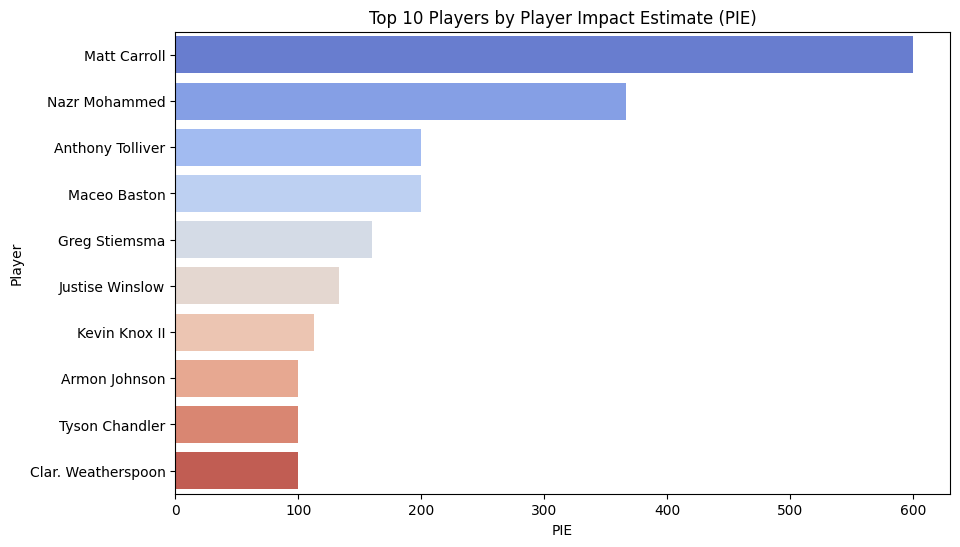

In [165]:
# Sort by PIE and take the top 10 players
top_10_pie = nba_df[['PLAYER', 'PIE']].sort_values(by='PIE', ascending=False).head(10)

# Bar plot of the top 10 players by PIE
plt.figure(figsize=(10, 6))
sns.barplot(x='PIE', y='PLAYER', data=top_10_pie, palette='coolwarm')
plt.title('Top 10 Players by Player Impact Estimate (PIE)')
plt.xlabel('PIE')
plt.ylabel('Player')

# Save the plot in the "Images" folder as a PNG file
plt.savefig('Images/PIE_plots.png')
plt.show()

Radar chart to show top PIE players' performance statistics:

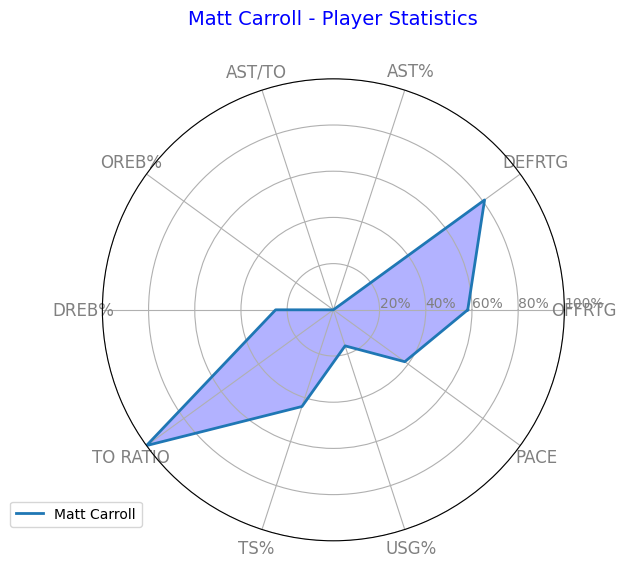

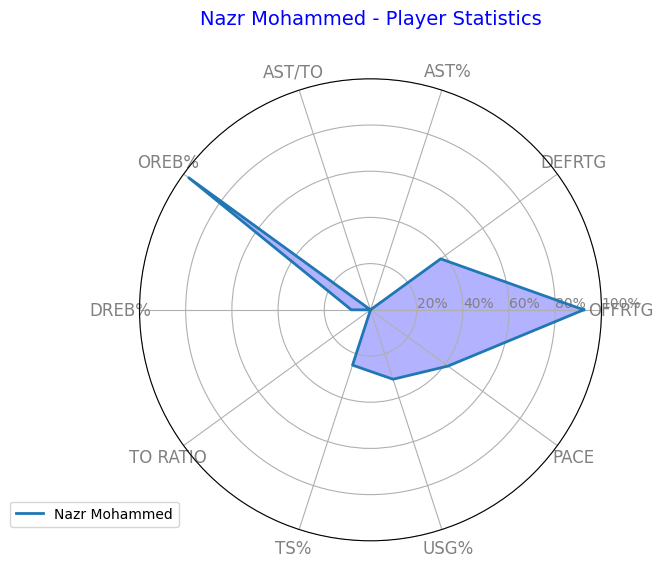

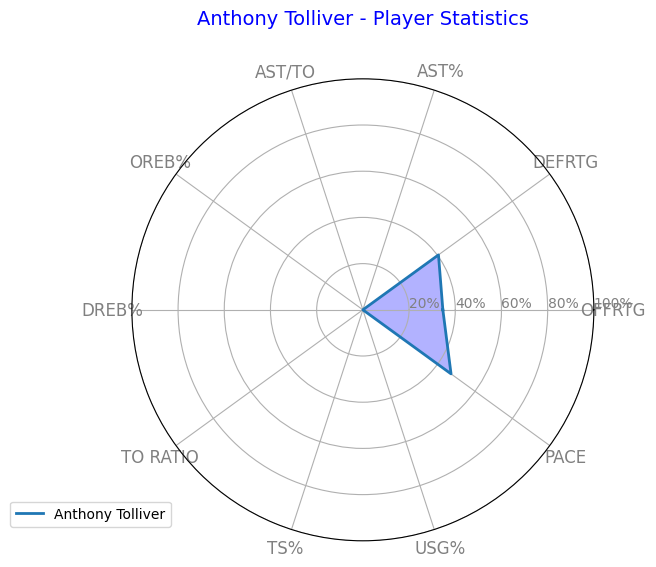

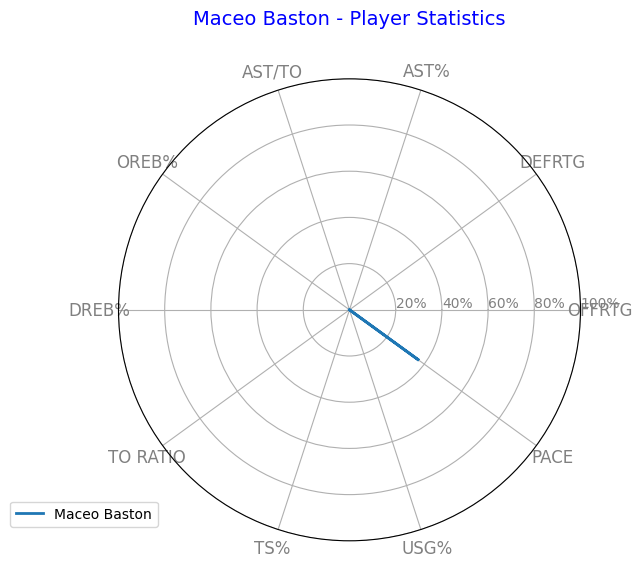

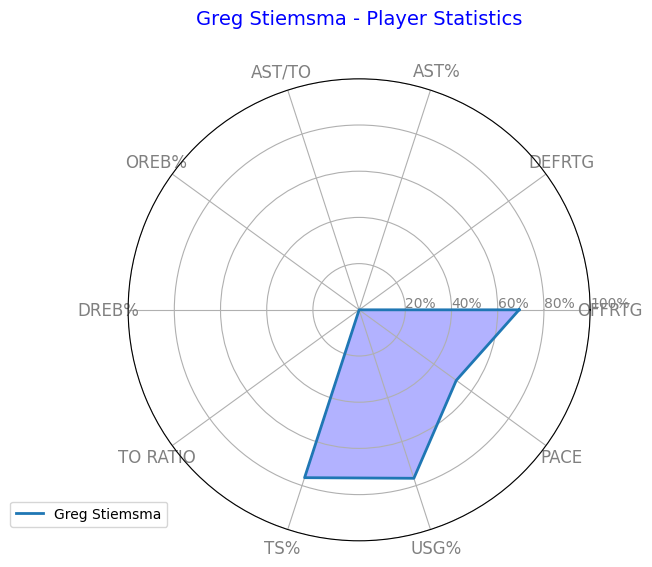

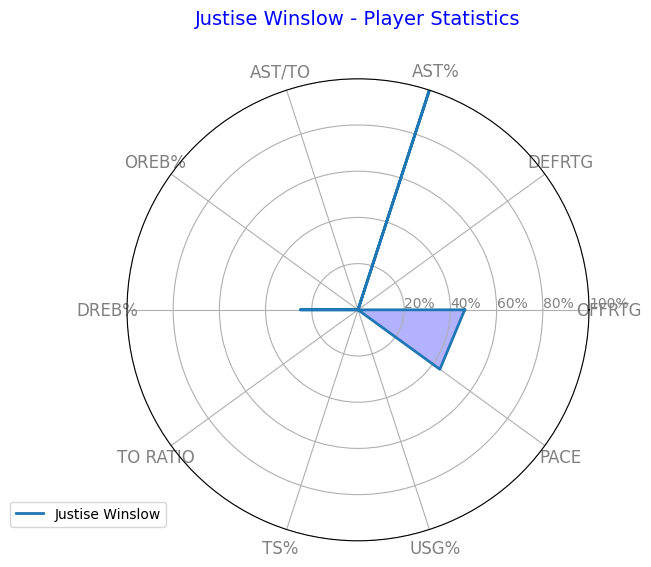

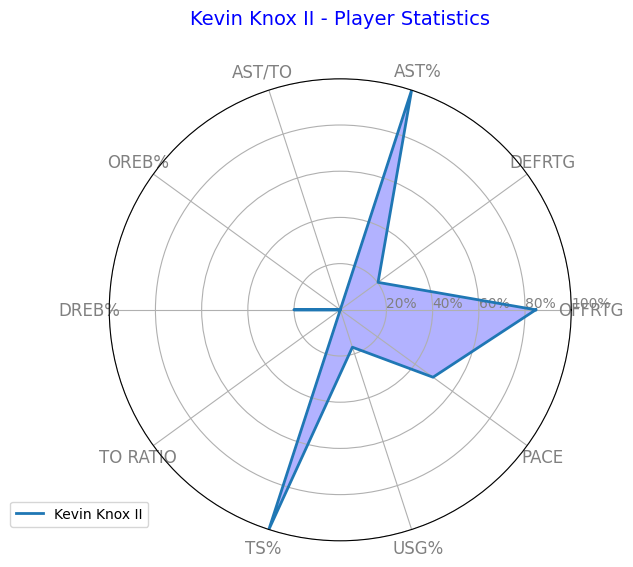

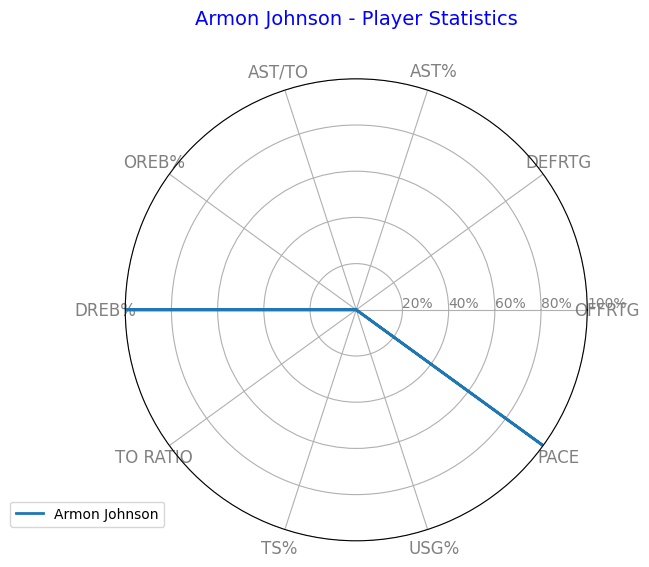

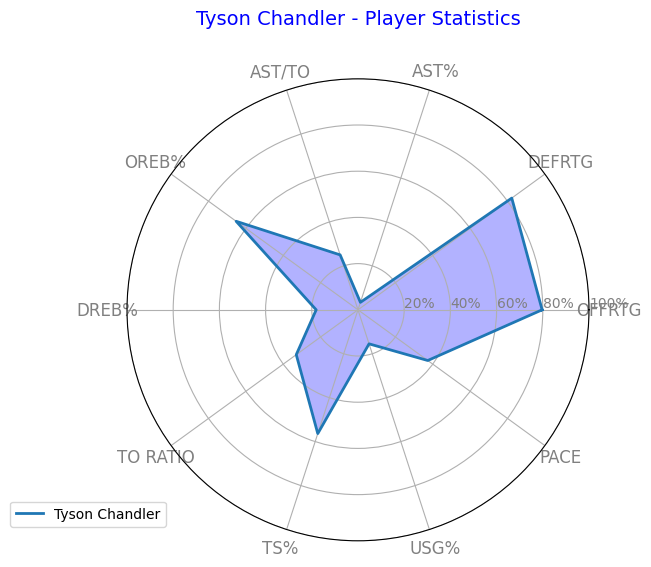

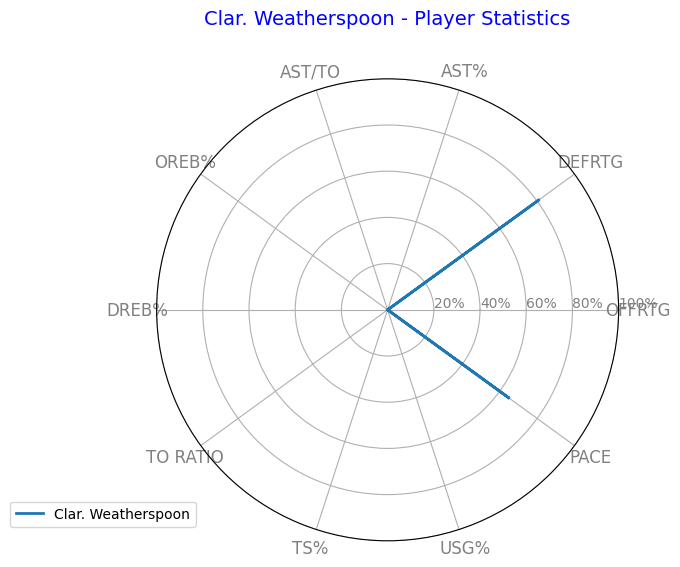

In [167]:
# Filter the dataset for the specific players
players = ['Matt Carroll', 'Nazr Mohammed', 'Anthony Tolliver', 'Maceo Baston',
        'Greg Stiemsma', 'Justise Winslow', 'Kevin Knox II', 'Armon Johnson', 
        'Tyson Chandler', 'Clar. Weatherspoon']
player_stats = nba_df[nba_df['PLAYER'].isin(players)]

# Define the player metrics to visualize
metrics = ['OFFRTG', 'DEFRTG', 'AST%', 'AST/TO', 'OREB%', 'DREB%', 'TO RATIO', 'TS%', 'USG%', 'PACE']

# Normalize the data to a 0-1 range for radar chart comparison
def normalize(df, columns):
    normalized_df = df[columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
    return normalized_df

# Normalize the selected metrics for the specific players
player_stats_normalized = normalize(player_stats, metrics)

# Function to create and display radar charts for each player
def create_radar_chart(player, player_data, metrics):
    # Add the first value again to close the radar chart
    player_data += player_data[:1]

    # Compute the angle of each axis for the radar chart
    N = len(metrics)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Close the circle

    # Create the radar chart
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot the player's stats
    ax.plot(angles, player_data, linewidth=2, linestyle='solid', label=player)
    ax.fill(angles, player_data, 'b', alpha=0.3)

    # Add labels
    plt.xticks(angles[:-1], metrics, color='grey', size=12)

    # Draw y-labels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["20%", "40%", "60%", "80%", "100%"], color="grey", size=10)
    plt.ylim(0, 1)

    # Title and legend
    plt.title(f'{player} - Player Statistics', size=14, color='blue', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
        # Save the radar chart to the "Images" folder
    plt.savefig(f'Images/{player}_radar_chart.png')

    # Show the radar chart
    plt.show()
    # Close the plot to avoid overlap when generating multiple charts
    plt.close()

# Loop through each player and generate a radar chart
for player in players:
    # Get the player's normalized stats
    player_data = player_stats_normalized[player_stats['PLAYER'] == player].iloc[0].values.tolist()
    
    # Create radar chart for the player
    create_radar_chart(player, player_data, metrics)



Observations:
Matt Carroll appears to be a solid defensive player with good defensive and offensive ratings but with limited contributions in playmaking, scoring, and rebounding. His low usage rate suggests he might not be a focal point of his team’s offense but contributes in other ways, such as minimizing turnovers and being efficient on defense.

Nazr Mohammed's profile highlights his effectiveness as an offensive rebounder and a decent contributor on offense, but he is less involved in playmaking, shooting, and high-tempo plays. His role likely focuses on being near the basket, grabbing offensive boards, and providing solid defense without being a major scorer or ball handler.



In [168]:
#Sort all data by year
nba_df_sorted_copy = nba_df.sort_values(by='YEAR', ascending=True).reset_index(drop=True)
nba_df_sorted_copy.head()

PLAYER TEAM  AGE  GP  W  L   MIN  OFFRTG  DEFRTG  NETRTG  ...  \
0   Steven Smith  MIA   36   3  1  2   2.1   100.0    83.3    16.7  ...   
1  Jannero Pargo  CHI   25   5  1  4  15.1   114.6    99.4    15.2  ...   
2   Kenny Thomas  SAC   27   5  1  4  30.7   107.7   118.7   -10.9  ...   
3  Kenyon Martin  DEN   27   5  1  4  32.8    97.5   105.4    -7.9  ...   
4    Kyle Korver  PHI   24   5  1  4  28.8   102.9   110.5    -7.6  ...   

   DREB%  REB%  TO RATIO  EFG%   TS%  USG%    PACE   PIE  POSS  YEAR  
0    0.0   0.0       0.0   0.0   0.0  12.5  106.30 -14.3    16  2005  
1    4.7   2.9      11.3  48.0  48.9  31.3  104.26   5.9   164  2005  
2   18.9  14.5      10.8  51.1  55.8  17.8   93.29  10.6   297  2005  
3   13.8   8.9       9.2  46.6  48.7  19.7   92.32   7.3   316  2005  
4    8.1   5.0      18.2  41.1  43.3  11.6   92.65   0.6   279  2005  

[5 rows x 24 columns]

In [169]:
#Understand data size and type
nba_df_sorted_copy.info()

#Check column names for dropping not needed columns later
nba_df_sorted_copy.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PLAYER     4149 non-null   object 
 1   TEAM       4149 non-null   object 
 2   AGE        4149 non-null   int64  
 3   GP         4149 non-null   int64  
 4   W          4149 non-null   int64  
 5   L          4149 non-null   int64  
 6   MIN        4149 non-null   float64
 7   OFFRTG     4149 non-null   float64
 8   DEFRTG     4149 non-null   float64
 9   NETRTG     4149 non-null   float64
 10  AST%       4149 non-null   float64
 11  AST/TO     4149 non-null   float64
 12  AST RATIO  4149 non-null   float64
 13  OREB%      4149 non-null   float64
 14  DREB%      4149 non-null   float64
 15  REB%       4149 non-null   float64
 16  TO RATIO   4149 non-null   float64
 17  EFG%       4149 non-null   float64
 18  TS%        4149 non-null   float64
 19  USG%       4149 non-null   float64
 20  PACE    

Index(['PLAYER', 'TEAM', 'AGE', 'GP', 'W', 'L', 'MIN', 'OFFRTG', 'DEFRTG',
       'NETRTG', 'AST%', 'AST/TO', 'AST RATIO', 'OREB%', 'DREB%', 'REB%',
       'TO RATIO', 'EFG%', 'TS%', 'USG%', 'PACE', 'PIE', 'POSS', 'YEAR'],
      dtype='object')

In [170]:
#Drop columns that are not needed for the analysis
nba_df_sorted_copy = nba_df_sorted_copy.drop(columns=['PLAYER', 'TEAM', 'GP', 'W', 'L', 
        'NETRTG', 'AST RATIO', 'REB%','POSS', 'YEAR'])

#Confirm the right columns are kept
nba_df_sorted_copy.columns

Index(['AGE', 'MIN', 'OFFRTG', 'DEFRTG', 'AST%', 'AST/TO', 'OREB%', 'DREB%',
       'TO RATIO', 'EFG%', 'TS%', 'USG%', 'PACE', 'PIE'],
      dtype='object')

Correlation heatmap of player metrics:

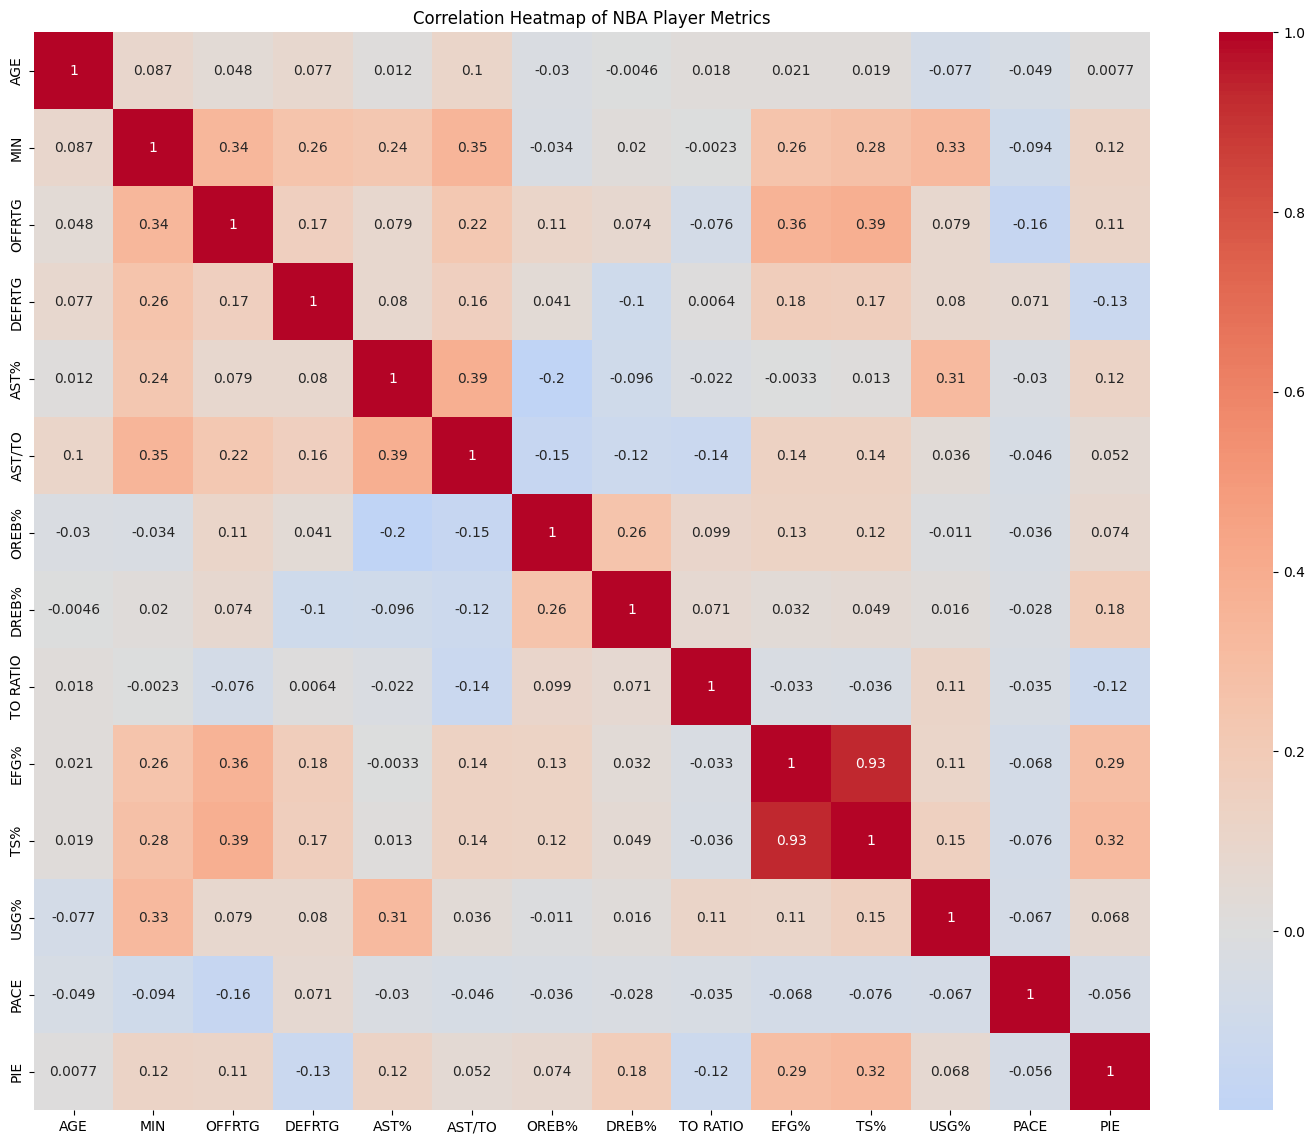

In [171]:
# Select only the numeric columns from the dataset for the correlation heatmap
numeric_columns = nba_df_sorted_copy.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix using only numeric columns
plt.figure(figsize=(18, 14))
sns.heatmap(nba_df_sorted_copy.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of NBA Player Metrics')
# Save the plot in the "Images" folder as a PNG file
plt.savefig('Images/Corr_heatmap.png')
plt.show()

Observations: Very high correlations between TS% and EFG%

In [172]:
#drop EFS% to avoid multicollearity issue
nba_df_sorted_copy = nba_df_sorted_copy.drop(columns=['EFG%'])

In [173]:
#Make a copy of the data for analysis
nba_df_sorted = nba_df_sorted_copy.copy()

In [174]:
#Redefine player metrics/independent variables columns after removing EFG%
numeric_columns = ['AGE', 'MIN', 'OFFRTG', 'DEFRTG', 'AST%', 'AST/TO', 'OREB%', 'DREB%', 
                'TO RATIO', 'TS%', 'USG%', 'PACE', 'PIE']

<h2>Data Diagnostics and Transformation<h2>

<h4> Outlier and  Skewness Diagnostics

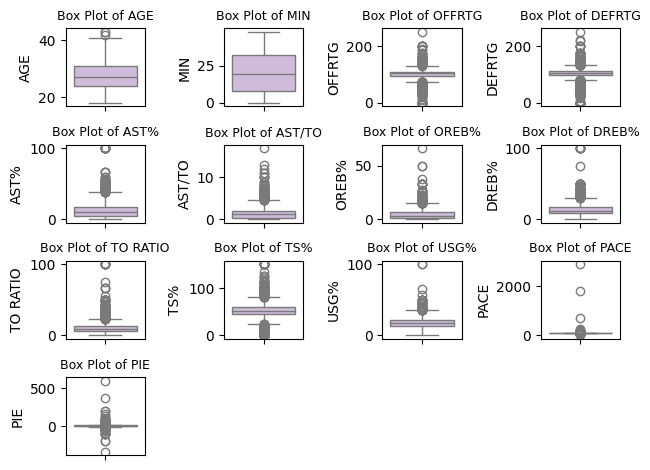

In [175]:
# Define a color for light purple
light_purple = "#D3B6E0"

# Create box plots for each variable in nba_df_scaled
for i, col in enumerate(nba_df_sorted.columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=nba_df_sorted[col],color=light_purple)
    plt.title(f'Box Plot of {col}', fontsize=9)

plt.tight_layout()

# Save the plot in the "Images" folder as a PNG file
plt.savefig('Images/Box_plots_outlier.png')

plt.show()

Observations: Outliers detected in a number of variables.

In [176]:
# Calculate IQR and detect outliers
def detect_outliers(df):
    outliers = {}
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Find outliers
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"{col}: {len(outliers[col])} outliers")
    
    return outliers

# Run the function to detect outliers
outliers_dict = detect_outliers(nba_df_sorted)

AGE: 3 outliers
MIN: 0 outliers
OFFRTG: 300 outliers
DEFRTG: 367 outliers
AST%: 157 outliers
AST/TO: 115 outliers
OREB%: 112 outliers
DREB%: 117 outliers
TO RATIO: 222 outliers
TS%: 474 outliers
USG%: 59 outliers
PACE: 152 outliers
PIE: 285 outliers


In [177]:
# Create a copy of the dataset without outliers
# Compare Mean and Std Before and After Removing Outliers:
nba_df_no_outlier = nba_df_sorted.copy()

# Identify numeric columns
numeric_columns = nba_df_no_outlier.select_dtypes(include=['number']).columns

# Remove outliers based on the IQR method
for col in numeric_columns:
    Q1 = nba_df_no_outlier[col].quantile(0.25)
    Q3 = nba_df_no_outlier[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    nba_df_no_outlier = nba_df_no_outlier[(nba_df_no_outlier[col] >= lower_bound) & (nba_df_no_outlier[col] <= upper_bound)]

# Compare basic statistics before and after removing outliers
print("Before Removing Outliers:\n", nba_df_sorted.describe())
print("\nAfter Removing Outliers:\n", nba_df_no_outlier.describe())

Before Removing Outliers:
                AGE          MIN       OFFRTG       DEFRTG         AST%  \
count  4149.000000  4149.000000  4149.000000  4149.000000  4149.000000   
mean     27.584960    20.172668   100.854061   104.469366    12.360641   
std       4.357829    12.831974    17.798167    18.186297    11.905208   
min      18.000000     0.000000     0.000000     0.000000     0.000000   
25%      24.000000     8.000000    95.200000    99.700000     4.300000   
50%      27.000000    19.500000   103.400000   106.100000     9.300000   
75%      31.000000    32.000000   109.700000   112.500000    17.700000   
max      43.000000    47.600000   250.000000   250.000000   100.000000   

            AST/TO        OREB%        DREB%     TO RATIO          TS%  \
count  4149.000000  4149.000000  4149.000000  4149.000000  4149.000000   
mean      1.374719     4.378838    13.131694    10.284358    49.949313   
std       1.360960     4.685497     8.465929     8.791870    19.390013   
min       

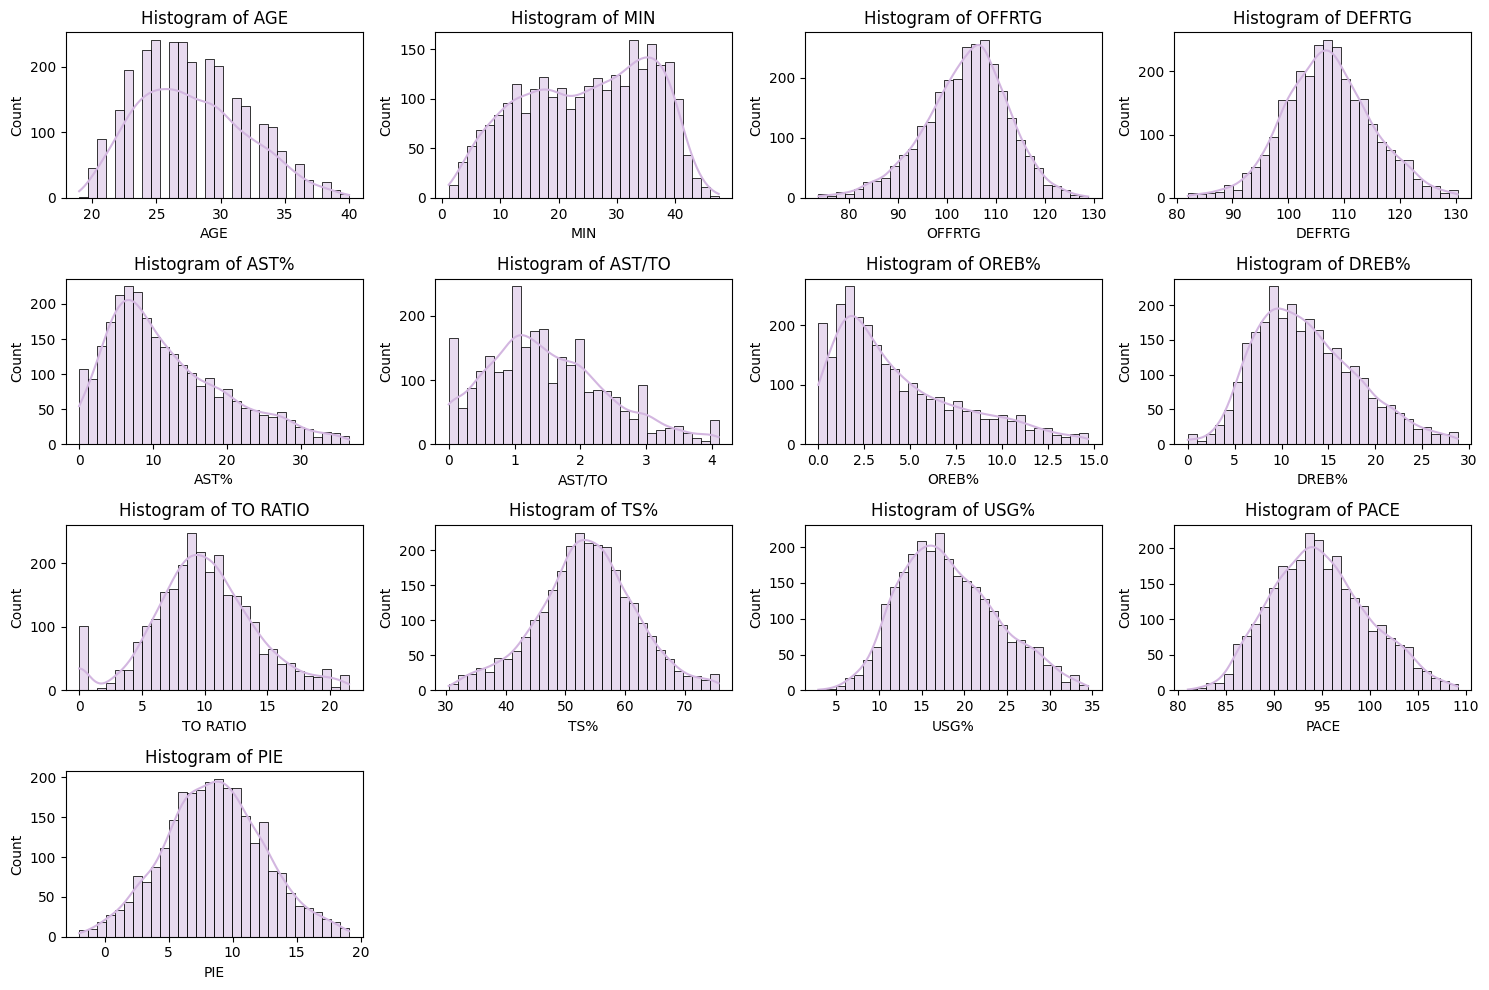

In [178]:
#Histogram plots for all variables to understand distribution
# Plot histograms for each variable
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)  # Create subplots
    sns.histplot(nba_df_no_outlier[col], kde=True, bins=30, color = light_purple)  # Plot histograms with KDE
    plt.title(f'Histogram of {col}')
plt.tight_layout()
# Save the plot in the "Images" folder as a PNG file
plt.savefig('Images/Histogram_plots_no_transformation.png')
plt.show()

Observations: a few variables are not normally distributed and are not in the same scale. We can to log transformation to address skewness.

In [179]:
# Check skewness for each variable
skewness_values = nba_df_no_outlier.apply(lambda x: skew(x.dropna()))
print("\nSkewness for each variable:\n", skewness_values)


Skewness for each variable:
 AGE         0.378158
MIN        -0.196106
OFFRTG     -0.373614
DEFRTG      0.079845
AST%        0.836744
AST/TO      0.523976
OREB%       0.947722
DREB%       0.521213
TO RATIO    0.065526
TS%        -0.077980
USG%        0.406038
PACE        0.275116
PIE         0.062623
dtype: float64


Observations: AST% and OREB% show moderate positive skewness and we can apply log transformation.

In [180]:
# Apply Yeo-Johnson transformation to reduce positive skewness
pt = PowerTransformer(method='yeo-johnson')

nba_df_no_outlier['AST%'] = pt.fit_transform(nba_df_no_outlier[['AST%']])
nba_df_no_outlier['OREB%'] = pt.fit_transform(nba_df_no_outlier[['OREB%']])

In [181]:
# Check skewness for each variable. Transformation helped correct skewness.
skewness_values = nba_df_no_outlier.apply(lambda x: skew(x.dropna()))
print("\nSkewness for each variable:\n", skewness_values)


Skewness for each variable:
 AGE         0.378158
MIN        -0.196106
OFFRTG     -0.373614
DEFRTG      0.079845
AST%       -0.034806
AST/TO      0.523976
OREB%      -0.025023
DREB%       0.521213
TO RATIO    0.065526
TS%        -0.077980
USG%        0.406038
PACE        0.275116
PIE         0.062623
dtype: float64


In [182]:
# Check for NaN values
print("Missing values:\n", nba_df_no_outlier[numeric_columns].isnull().sum())

# Check for infinite values
print("\nInfinite values:\n", np.isinf(nba_df_no_outlier[numeric_columns]).sum())

Missing values:
 AGE         0
MIN         0
OFFRTG      0
DEFRTG      0
AST%        0
AST/TO      0
OREB%       0
DREB%       0
TO RATIO    0
TS%         0
USG%        0
PACE        0
PIE         0
dtype: int64

Infinite values:
 AGE         0
MIN         0
OFFRTG      0
DEFRTG      0
AST%        0
AST/TO      0
OREB%       0
DREB%       0
TO RATIO    0
TS%         0
USG%        0
PACE        0
PIE         0
dtype: int64


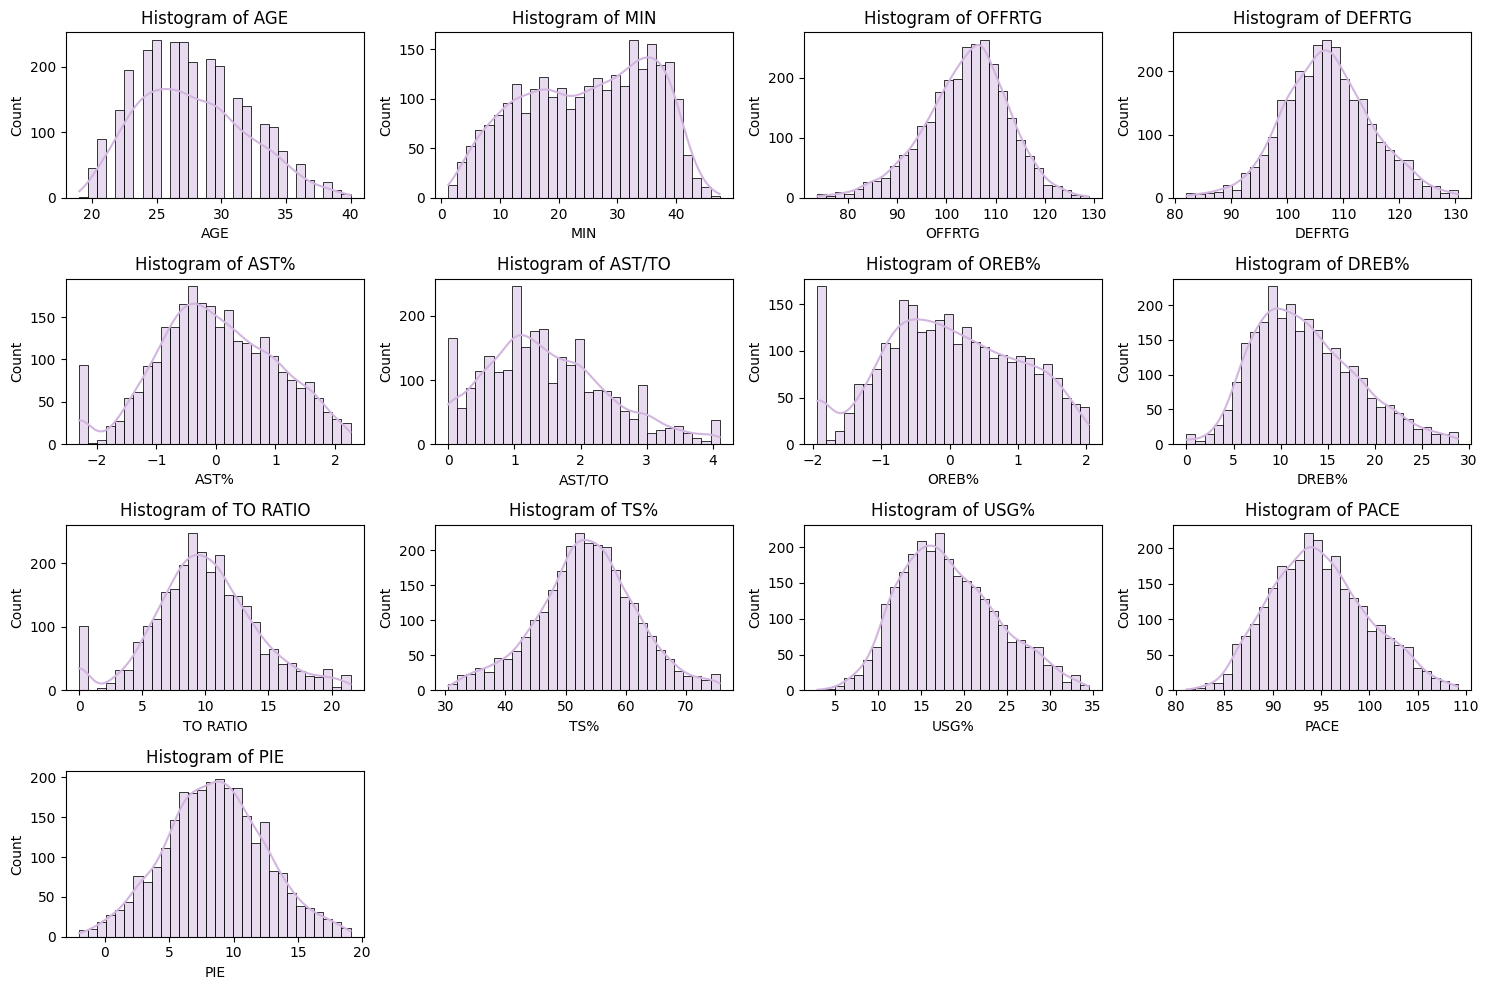

In [183]:
#Histogram plots for all variables to check distribution. Skewness is reduced.
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)  # Create subplots
    sns.histplot(nba_df_no_outlier[col], kde=True, bins=30, color = light_purple)  # Plot histograms with KDE
    plt.title(f'Histogram of {col}')
plt.tight_layout()
# Save the plot in the "Images" folder as a PNG file
plt.savefig('Images/Histogram_plots_transformation.png')
plt.show()

In [184]:
# Display basic statistics for transformed variables
print("Basic Statistics:\n")
print(nba_df_no_outlier.describe())

Basic Statistics:

               AGE          MIN       OFFRTG       DEFRTG          AST%  \
count  2733.000000  2733.000000  2733.000000  2733.000000  2.733000e+03   
mean     27.759605    24.756824   104.019027   107.112075 -1.559918e-17   
std       4.242255    10.816409     8.588419     7.982071  1.000183e+00   
min      19.000000     1.200000    73.800000    82.000000 -2.297955e+00   
25%      24.000000    15.900000    98.800000   101.800000 -6.761590e-01   
50%      27.000000    25.700000   104.800000   106.900000 -5.084153e-02   
75%      31.000000    34.200000   109.800000   112.200000  7.251108e-01   
max      40.000000    47.400000   128.900000   130.400000  2.261583e+00   

            AST/TO         OREB%        DREB%     TO RATIO          TS%  \
count  2733.000000  2.733000e+03  2733.000000  2733.000000  2733.000000   
mean      1.490432 -3.119836e-17    12.682547     9.942810    53.448225   
std       0.921334  1.000183e+00     5.455791     4.127904     8.235750   
min  

Observations: We will need standardize those data for the analysis part as the scale of each variable is pretty different.

<h2> Analysis <h2>

<h4> Base Model 1 - Regression Analysis

In [185]:
# Linear Regression Analysis
# Define X (features) and y (target)
X = nba_df_no_outlier.drop(['PIE'], axis=1)  # Use all features except PIE
y = nba_df_no_outlier['PIE']  # Target variable (PIE)

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    PIE   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1191.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:22:21   Log-Likelihood:                -5071.6
No. Observations:                2733   AIC:                         1.017e+04
Df Residuals:                    2720   BIC:                         1.025e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1745      0.777      6.656      0.0

Observation: AST/TO  is not statistically significant, so we can drop it later.

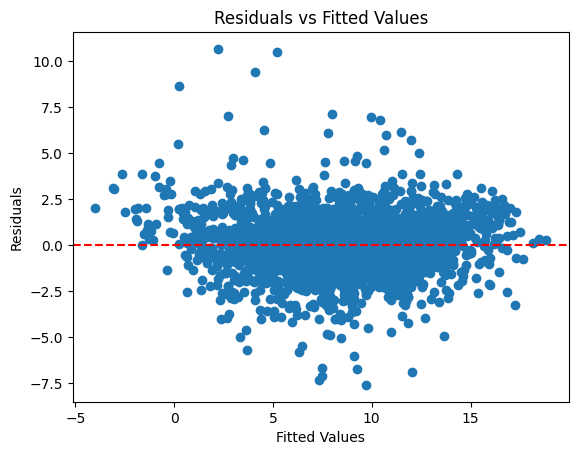

In [186]:
# Get the residuals and fitted values
residuals = model.resid
fitted_values = model.fittedvalues

# Plot residuals vs fitted values
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.savefig('Images/Residual_BaseModel1.png')
plt.show()

#residual distribution seem random which is a good sign.

In [187]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

     feature         VIF
0      const  686.285050
1        AGE    1.041581
2        MIN    1.583017
3     OFFRTG    1.409868
4     DEFRTG    1.093994
5       AST%    2.998479
6     AST/TO    2.502552
7      OREB%    1.458214
8      DREB%    1.356537
9   TO RATIO    1.336371
10       TS%    1.243015
11      USG%    1.922089
12      PACE    1.161220


Observation: There are no immediate multicollinearity issues are apparent based on these VIFs, so there's no pressing need to drop any features.

<h4> Base Model 1 Final - Regression Analysis - Removing AST/TO

In [189]:
# Linear Regression model - removing AST/TO
# Define X (features) and y (target)
X = nba_df_no_outlier.drop(['PIE','AST/TO'], axis=1)  # Use all features except PIE
y = nba_df_no_outlier['PIE']  # Target variable (PIE)

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    PIE   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1298.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        19:23:19   Log-Likelihood:                -5072.5
No. Observations:                2733   AIC:                         1.017e+04
Df Residuals:                    2721   BIC:                         1.024e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2680      0.774      6.804      0.0

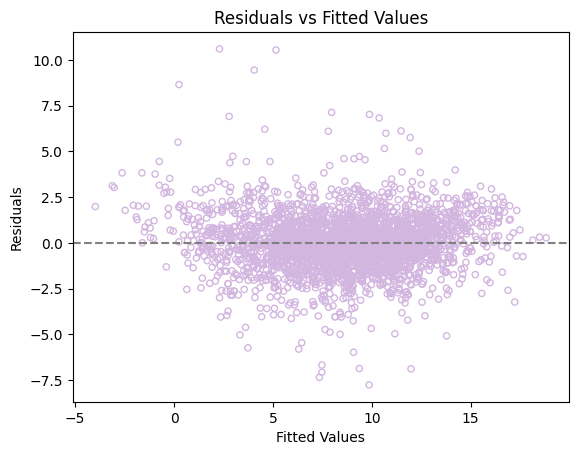

In [193]:
# Get the residuals and fitted values
residuals = model.resid
fitted_values = model.fittedvalues

# Plot residuals vs fitted values with smaller dots and no fill
plt.scatter(fitted_values, residuals, color=light_purple, s=20, edgecolor=light_purple, facecolors='none')
plt.axhline(0, color='grey', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.savefig('Images/Residual_BaseModel1Final.png')
plt.show()

Observation: (1) The residuals are randomly scattered around the horizontal axis. This suggests that the relationship between the independent and dependent variables is linear, and the model has captured the linearity well.
(2) Homoscedasticity: While there seems to be some variation in the density of residuals at different fitted values, it's not extreme. The plot generally shows a fairly constant spread, which suggests that the assumption of homoscedasticity holds reasonably well.

In [194]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

     feature         VIF
0      const  680.586845
1        AGE    1.040905
2        MIN    1.562079
3     OFFRTG    1.374187
4     DEFRTG    1.091477
5       AST%    1.527547
6      OREB%    1.457946
7      DREB%    1.356301
8   TO RATIO    1.087086
9        TS%    1.237602
10      USG%    1.487817
11      PACE    1.160423


Observation: There are no immediate multicollinearity issues are apparent based on these VIFs, so there's no pressing need to drop any features.

<h4>  Unsupervised Learning - Kmeans

In [195]:
# Apply Standardization
scaler = StandardScaler()
nba_df_scaled_no_outlier = pd.DataFrame(scaler.fit_transform(nba_df_no_outlier[numeric_columns]), columns=numeric_columns)

In [196]:
# Define the independent variables (performance metrics)
performance_metrics = ['MIN', 'OFFRTG', 'DEFRTG', 'TS%', 'USG%', 'AST%', 
'AST/TO', 'OREB%', 'DREB%', 'TO RATIO', 'PACE', 'AGE']

In [197]:
# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the spread_df DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance

# Create a list to store inertia values
inertia = []
# Create a list to store the values of k
k = list(range(1, 16))

# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the spread_df DataFrame
# Append the value of the computed inertia from the inertia_ attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=42)
    k_model.fit(nba_df_scaled_no_outlier[performance_metrics])
    inertia.append(k_model.inertia_)
    
# Create a Dictionary that holds the list values for k and inertia
elbow_data = {"k": k, "inertia": inertia}

# Create a DataFrame using the elbow_data Dictionary
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

# Plot the DataFrame
df_elbow.hvplot.line(
    x="k",
    y="inertia",
    title="Elbow Curve",
    xticks=k
)

:Curve   [k]   (inertia)

Observation: Based on the Elbow Curve above, it appears that 4 clusters could be a reasonable choice, as it is where the curve starts to flatten. We will confirm using the silhouette scores.


     k  silhouette_score
0    2          0.124133
1    3          0.106400
2    4          0.102991
3    5          0.092485
4    6          0.095291
5    7          0.093030
6    8          0.089057
7    9          0.086263
8   10          0.082583
9   11          0.084262
10  12          0.073325
11  13          0.071612
12  14          0.072147
13  15          0.073156


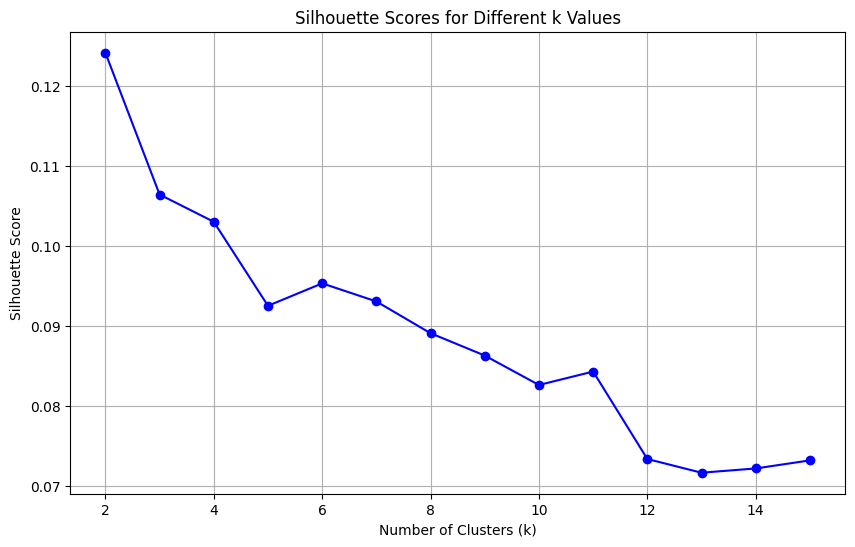

In [200]:
# Initialize list to store silhouette scores for each k
silhouette_scores = []

# Define the range for k
k_values = list(range(2, 16))  # Start from 2 because silhouette score is not defined for k=1

# Loop through different values of k and compute silhouette score
for k in k_values:
    # Initialize the KMeans model with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Fit the model to the performance metrics
    kmeans.fit(nba_df_scaled_no_outlier[performance_metrics])
    
    # Predict the cluster labels
    cluster_labels = kmeans.labels_
    
    # Calculate the silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(nba_df_scaled_no_outlier[performance_metrics], cluster_labels)
    
    # Append the silhouette score to the list
    silhouette_scores.append(silhouette_avg)

# Create a DataFrame to store the k values and their corresponding silhouette scores
silhouette_data = pd.DataFrame({'k': k_values, 'silhouette_score': silhouette_scores})

# Display the silhouette scores
print(silhouette_data)

# Optionally, plot the silhouette scores for better visualization
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k Values')
plt.grid(True)
plt.savefig('Images/Silhouette_Unsupervised_KMeans.png')
plt.show()

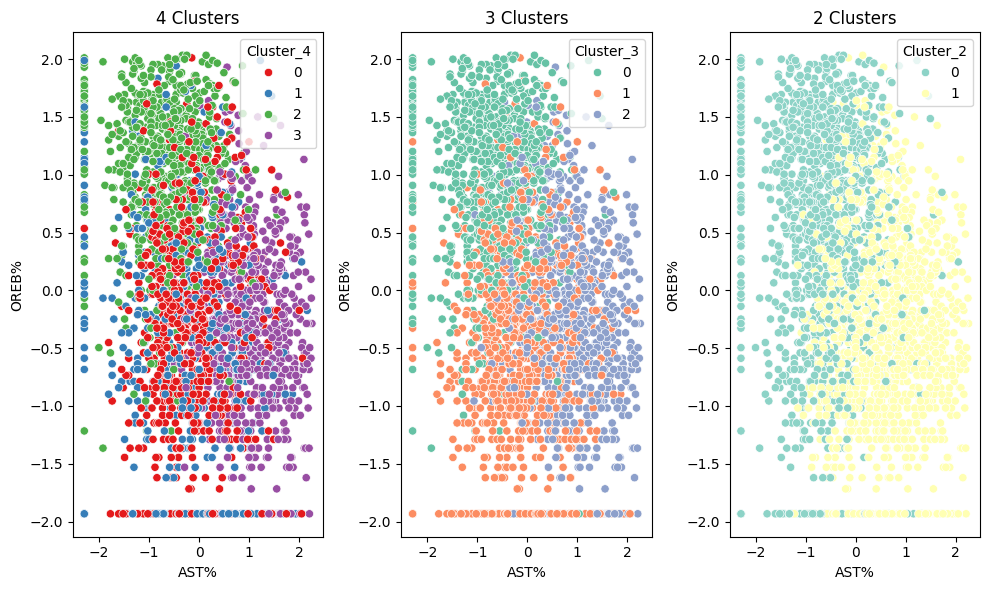

In [199]:
#Plot 2-4 clusters
# Fit KMeans with 4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=42)
cluster_labels_4 = kmeans_4.fit_predict(nba_df_scaled_no_outlier[performance_metrics])

# Fit KMeans with 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=42)
cluster_labels_3 = kmeans_3.fit_predict(nba_df_scaled_no_outlier[performance_metrics])

# Fit KMeans with 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=42)
cluster_labels_2 = kmeans_2.fit_predict(nba_df_scaled_no_outlier[performance_metrics])

# Add the cluster labels to the DataFrame for both models
nba_df_scaled_no_outlier['Cluster_4'] = cluster_labels_4
nba_df_scaled_no_outlier['Cluster_3'] = cluster_labels_3
nba_df_scaled_no_outlier['Cluster_2'] = cluster_labels_2

# Visualize both 10 and 11 clusters using scatter plots (e.g., using OFFRTG and DEFRTG as in the previous example)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
sns.scatterplot(x=nba_df_scaled_no_outlier['AST%'], 
                y=nba_df_scaled_no_outlier['OREB%'], 
                hue=nba_df_scaled_no_outlier['Cluster_4'], 
                palette='Set1')
plt.title('4 Clusters')

plt.subplot(1, 3, 2)
sns.scatterplot(x=nba_df_scaled_no_outlier['AST%'], 
                y=nba_df_scaled_no_outlier['OREB%'], 
                hue=nba_df_scaled_no_outlier['Cluster_3'], 
                palette='Set2')
plt.title('3 Clusters')

plt.subplot(1, 3, 3)
sns.scatterplot(x=nba_df_scaled_no_outlier['AST%'], 
                y=nba_df_scaled_no_outlier['OREB%'], 
                hue=nba_df_scaled_no_outlier['Cluster_2'], 
                palette='Set3')
plt.title('2 Clusters')

plt.tight_layout()
plt.savefig('Images/Clusters_4_3_2.png')
plt.show()


Observation: None of the clusters look particularly helpful, so I will choose cluster 4 for avoiding underfitting.

In [201]:
# Initialize the K-Means model with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)

# Fit the K-Means model to the performance metrics in the nba_df_scaled_no_outliers DataFrame
kmeans.fit(nba_df_scaled_no_outlier[performance_metrics])

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the original DataFrame
nba_df_scaled_no_outlier['Cluster'] = cluster_labels

# Display the first few rows with the cluster labels
print(nba_df_scaled_no_outlier[['Cluster'] + performance_metrics].head())

   Cluster       MIN    OFFRTG    DEFRTG       TS%      USG%      AST%  \
0        3 -0.892957  1.232230 -0.966351 -0.552355  2.291220  1.269136   
1        2  0.549560  0.428676  1.452010  0.285609 -0.074183  0.226103   
2        2  0.743745 -0.759187 -0.214529 -0.576644  0.258726 -0.457770   
3        1  0.373869 -0.130319  0.424520 -1.232442 -1.160516 -0.364138   
4        2  1.169102 -0.433107 -0.064165 -0.637366 -0.424613 -0.333800   

     AST/TO     OREB%     DREB%  TO RATIO      PACE       AGE  
0 -0.261008 -0.957195 -1.463401  0.328844  1.861525 -0.650623  
1  0.010387  1.514536  1.139815  0.207695 -0.309263 -0.179090  
2 -0.684385  0.274201  0.204857 -0.179981 -0.501211 -0.179090  
3 -0.532403 -0.451942 -0.840096  2.000701 -0.435909 -0.886390  
4 -0.727808 -0.451942  2.826405  1.249577 -0.912809  0.763978  


In [202]:
# Predict the model segments (4 clusters)
# Predict the clusters for the dataset
predicted_clusters = kmeans.predict(nba_df_scaled_no_outlier[performance_metrics])

# Create a new DataFrame with the original data and the predicted clusters
nba_df_with_clusters = nba_df_scaled_no_outlier.copy()
nba_df_with_clusters['Predicted_Cluster'] = predicted_clusters

# Display the first few rows of the new DataFrame with predicted clusters
print(nba_df_with_clusters[['Predicted_Cluster'] + performance_metrics].head())


   Predicted_Cluster       MIN    OFFRTG    DEFRTG       TS%      USG%  \
0                  3 -0.892957  1.232230 -0.966351 -0.552355  2.291220   
1                  2  0.549560  0.428676  1.452010  0.285609 -0.074183   
2                  2  0.743745 -0.759187 -0.214529 -0.576644  0.258726   
3                  1  0.373869 -0.130319  0.424520 -1.232442 -1.160516   
4                  2  1.169102 -0.433107 -0.064165 -0.637366 -0.424613   

       AST%    AST/TO     OREB%     DREB%  TO RATIO      PACE       AGE  
0  1.269136 -0.261008 -0.957195 -1.463401  0.328844  1.861525 -0.650623  
1  0.226103  0.010387  1.514536  1.139815  0.207695 -0.309263 -0.179090  
2 -0.457770 -0.684385  0.274201  0.204857 -0.179981 -0.501211 -0.179090  
3 -0.364138 -0.532403 -0.451942 -0.840096  2.000701 -0.435909 -0.886390  
4 -0.333800 -0.727808 -0.451942  2.826405  1.249577 -0.912809  0.763978  


Model Evaluation

In [203]:
# Get inertia (within-cluster sum of squares)
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")

Inertia: 24577.458368954474


Observation: This value is quite high, suggesting that the clusters are not very compact, and there's room for improvement in terms of clustering quality.

In [204]:
# Calculate silhouette score
silhouette_avg = silhouette_score(nba_df_scaled_no_outlier[performance_metrics], cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.1029911614449265


Observation: Silhouette score is close to 0. This implies that the clusters are overlapping and not clearly distinguishable. This suggests that KMeans is not finding well-separated clusters in the current data setup.

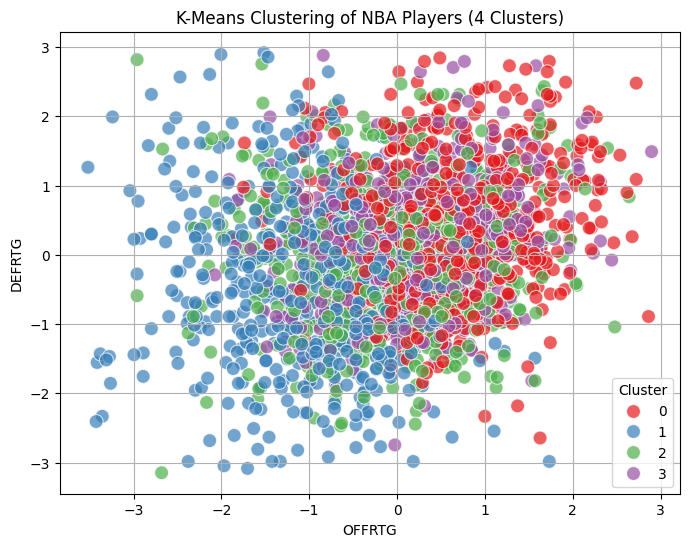

In [205]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=nba_df_scaled_no_outlier['OFFRTG'], 
                y=nba_df_scaled_no_outlier['DEFRTG'], 
                hue=nba_df_scaled_no_outlier['Cluster'], 
                palette='Set1', 
                s=100, alpha=0.7)
plt.title('K-Means Clustering of NBA Players (4 Clusters)')
plt.xlabel('OFFRTG')
plt.ylabel('DEFRTG')
plt.grid(True)
plt.savefig('Images/KMeans_Clusters_of_NBA_Players.png')
plt.show()


Observation: The K-Means clustering is not performing well based on the low silhouette scores and the inertia values obtained. This suggests that the chosen clusters may not be capturing distinct, meaningful patterns within the player performance data. Thus, we will proceed with PCA dimension reduction for two main reasons: (1) Improved Feature Representation, (2) Simplified Clustering.

<h4> PCA Dimension Reduction

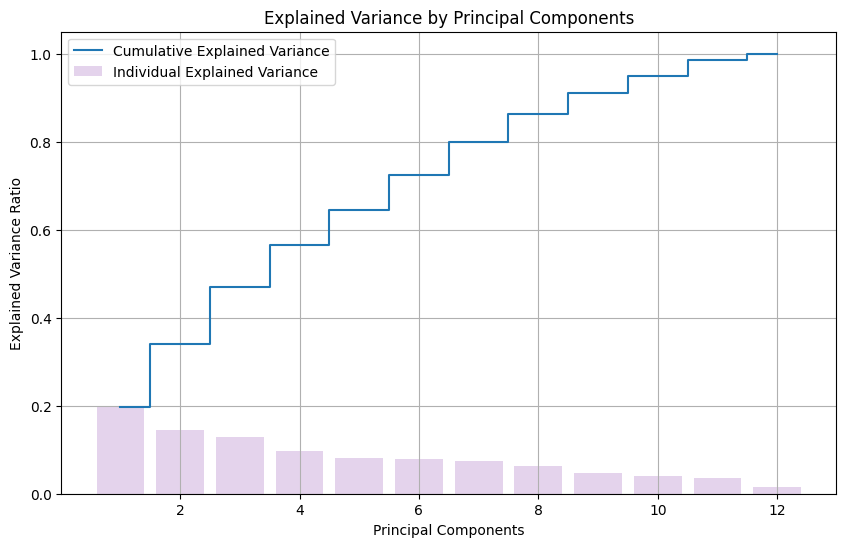

(array([0.19621791, 0.14490323, 0.12805731, 0.09626104, 0.08051984,
        0.07913323, 0.07533221, 0.06295523, 0.04679734, 0.03996923,
        0.03565699, 0.01419643]),
 array([0.19621791, 0.34112113, 0.46917844, 0.56543948, 0.64595932,
        0.72509256, 0.80042477, 0.86338001, 0.91017735, 0.95014658,
        0.98580357, 1.        ]))

In [206]:
# Perform PCA on the performance metrics
pca = PCA()
pca_result = pca.fit_transform(nba_df_scaled_no_outlier[performance_metrics])

# Explained variance ratio to determine how many components to retain
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance to determine how many components to keep
cumulative_variance = explained_variance.cumsum()

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Individual Explained Variance', color=light_purple)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('Images/PCA_Variance_Ratio.png')
plt.show()

# Output the explained variance and cumulative variance
explained_variance, cumulative_variance


Observation: The cumulative explained variance plateaus after around 6-7 components, capturing about 80-90% of the variance. I will go with 7 components.

In [207]:
# Set the number of components to 7 based on the explained variance plot
n_components = 7

# Re-run PCA with 7 components
pca = PCA(n_components=n_components)
pca_transformed_data = pca.fit_transform(nba_df_scaled_no_outlier[performance_metrics])

# Convert the PCA result into a DataFrame
pca_columns = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(pca_transformed_data, columns=pca_columns)

# Combine the PCA-transformed data with the original dataset's dependent variable (PIE) or any other relevant columns
nba_pca_df = pd.concat([pca_df, nba_df_scaled_no_outlier[['PIE']].reset_index(drop=True)], axis=1)

# Display the new PCA-transformed DataFrame with 10 components
nba_pca_df.head()


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.470482 -1.308445 -0.464256 -1.994413 -0.068276  0.515462 -1.336032   
1  0.058555  2.032722  0.201299 -0.289622  0.603737  0.024636  0.772566   
2 -0.533387  0.219021 -1.001466  0.026288 -0.254548 -0.671677  0.606280   
3 -0.711031 -0.515306 -0.948337 -0.423404 -1.172393  0.761689 -0.212082   
4 -0.754755  1.679976 -1.534591  0.835465  0.442003  0.778244  0.849036   

        PIE  
0 -0.687023  
1  0.527488  
2 -0.325254  
3 -2.056579  
4  0.940939

Run K-Means on the PCA dataframe

In [208]:
# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the spread_df DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance

# Create a list to store inertia values
inertia = []
# Create a list to store the values of k
k = list(range(1, 16))

# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the spread_df DataFrame
# Append the value of the computed inertia from the inertia_ attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=42)
    k_model.fit(pca_df)
    inertia.append(k_model.inertia_)
    
# Create a Dictionary that holds the list values for k and inertia
elbow_data = {"k": k, "inertia": inertia}

# Create a DataFrame using the elbow_data Dictionary
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

# Plot the DataFrame
df_elbow.hvplot.line(
    x="k",
    y="inertia",
    title="Elbow Curve",
    xticks=k
)

:Curve   [k]   (inertia)

k=4 seems reasonable.

     k  silhouette_score
0    2          0.151009
1    3          0.133667
2    4          0.132912
3    5          0.119636
4    6          0.120949
5    7          0.111534
6    8          0.114923
7    9          0.110743
8   10          0.111568
9   11          0.115024
10  12          0.113171
11  13          0.110583
12  14          0.109620
13  15          0.108253


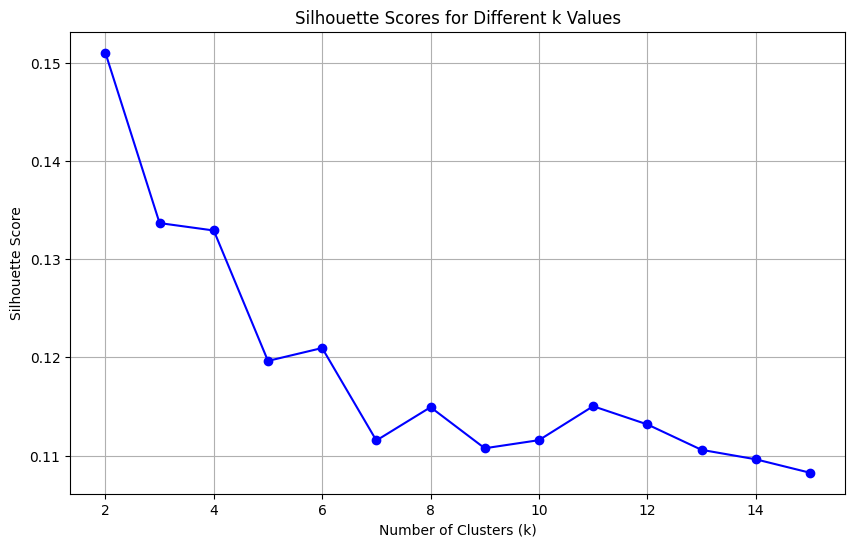

In [209]:
# Initialize list to store silhouette scores for each k
silhouette_scores = []

# Define the range for k
k_values = list(range(2, 16))  # Start from 2 because silhouette score is not defined for k=1

# Loop through different values of k and compute silhouette score
for k in k_values:
    # Initialize the KMeans model with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Fit the model to the performance metrics
    kmeans.fit(pca_df)
    
    # Predict the cluster labels
    cluster_labels = kmeans.labels_
    
    # Calculate the silhouette score for the current number of clusters
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    
    # Append the silhouette score to the list
    silhouette_scores.append(silhouette_avg)

# Create a DataFrame to store the k values and their corresponding silhouette scores
silhouette_data = pd.DataFrame({'k': k_values, 'silhouette_score': silhouette_scores})

# Display the silhouette scores
print(silhouette_data)

# Optionally, plot the silhouette scores for better visualization
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k Values')
plt.grid(True)
plt.savefig('Images/PCA_Silhouette_KMeans.png')
plt.show()

silhouette_scores suggests k = 2 is the optimal, but I think 2 clusters may under fit the data, so we will visualize the cluster.

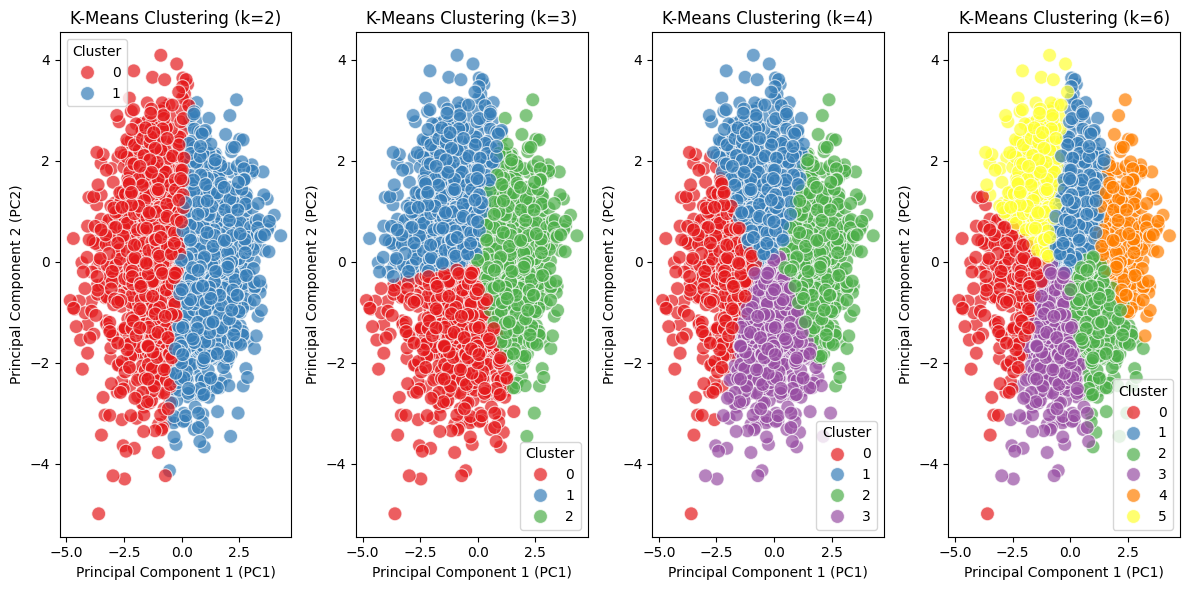

In [210]:
# Fit KMeans and plot clusters
# Create a figure with 4 subplots to compare the different k values with top silhouette_scores
k_values = [2, 3, 4, 6]
plt.figure(figsize=(12, 6))

for idx, k in enumerate(k_values, 1):
    # Fit K-Means with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    pca_df['cluster'] = kmeans.fit_predict(pca_df.iloc[:, :2])  # Use only first 2 components for the scatter plot

    # Create scatter plot for each k
    plt.subplot(1, 4, idx)
    sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='Set1', s=100, alpha=0.7)
    plt.title(f'K-Means Clustering (k={k})')
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.legend(title='Cluster')

plt.tight_layout()
plt.savefig('Images/PCA_KMeans_Clusters.png')
plt.show()

Observation: Kmeans with PCA reduction is still not very helpful in explaining/predicting this model given the low silhouette scores and the inertia values obtained. 

<h4>  Model 2 -  Run Random Forest with PCA Transformed Data to Predict Performance

In [211]:
# Split the data into features (X) and target (y) before scaling
X = nba_df_no_outlier[performance_metrics]
y = nba_df_no_outlier['PIE']  # The dependent variable (Player Impact Estimate)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Standardization to training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler for test data

# Apply PCA to the scaled training data
n_components = 7
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Convert the PCA result into DataFrames
pca_columns = [f'PC{i+1}' for i in range(n_components)]
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns)

# Initialize and fit the Random Forest Regressor using PCA-transformed data and cluster labels
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca_df, y_train)

# Predict the test set
y_pred = rf_model.predict(X_test_pca_df)

# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R² Score: {r2}')

# Feature importance analysis
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train_pca_df.columns)

# Sort the feature importances in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

# Display the top 10 most important features
print("Top 10 Important Features:\n", sorted_importances.head(10))


Mean Squared Error (MSE): 5.594575937842779
Root Mean Squared Error (RMSE): 2.3652855932937102
Mean Absolute Error (MAE): 1.7883254113345521
R² Score: 0.6117388671600409
Top 10 Important Features:
 PC2    0.394685
PC1    0.227819
PC7    0.119599
PC5    0.094126
PC3    0.061782
PC6    0.054628
PC4    0.047360
dtype: float64


Observation: 

(1) Root Mean Squared Error (RMSE): An RMSE of 2.4 suggests that, on average, the model’s predictions are off by around 2.4 PIE points. 
(2) Mean Absolute Error (MAE): An MAE of 1.8 means that, on average, the model is predicting the player performance (PIE) with an absolute error of 1.8 PIE points. This is a measure of how far off the model is from the actual performance without over-penalizing large errors.
(3) R² Score: R² score of 0.61 suggests that the model explains 61% of the variance in the player performance metric (PIE). While this indicates that the model captures much variability in the data, there is still 40% of the variance unexplained, which suggests that the model could potentially be improved.

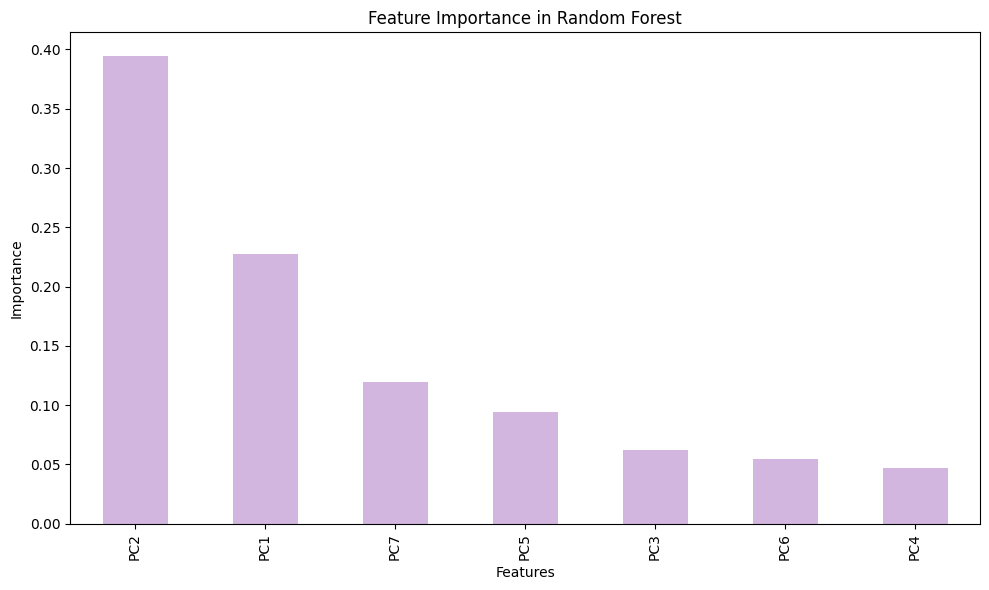

In [212]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar', color=light_purple)
plt.title('Feature Importance in Random Forest')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('Images/PCA_RandomForest_Feature_Importance.png')
plt.show()

Observations:

(1) PC2 and PC1 are the most important principal components, explaining the largest amount of variance in player performance.
(2) Cluster labels also contributed somewhat to the prediction, but not as strongly as the top principal components.
(3) PC7, PC5, and PC3 also contribute, but to a lesser extent.

In [213]:
# Use PCA loadings to show how much each original feature (e.g., MIN, AST%, TS%) contributes to each principal component (PC1, PC2, etc.).
# Get the PCA components (loadings)
pca_loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.components_))], index=performance_metrics)

# Show the loading matrix (coefficients of each feature in each principal component)
print("PCA Loadings (Top 10 Principal Components):")
print(pca_loadings.iloc[:, :10])

# To understand which features contribute most to each principal component:
# PC1:
print("\nTop features contributing to PC1:")
print(pca_loadings['PC1'].sort_values(ascending=False))

# PC2:
print("\nTop features contributing to PC2:")
print(pca_loadings['PC2'].sort_values(ascending=False))

# PC3:
print("\nTop features contributing to PC3:")
print(pca_loadings['PC3'].sort_values(ascending=False))

# PC4:
print("\nTop features contributing to PC4:")
print(pca_loadings['PC4'].sort_values(ascending=False))

# PC5:
print("\nTop features contributing to PC5:")
print(pca_loadings['PC5'].sort_values(ascending=False))

# PC6:
print("\nTop features contributing to PC6:")
print(pca_loadings['PC6'].sort_values(ascending=False))

# PC7:
print("\nTop features contributing to PC7:")
print(pca_loadings['PC7'].sort_values(ascending=False))

PCA Loadings (Top 10 Principal Components):
               PC1       PC2       PC3       PC4       PC5       PC6       PC7
MIN       0.404062  0.379245 -0.135504  0.058971 -0.151881 -0.221922  0.044187
OFFRTG    0.292240  0.296104  0.430076  0.090276 -0.086627 -0.017939 -0.143904
DEFRTG    0.172019  0.120064  0.290819 -0.363704 -0.173292 -0.008061  0.692194
TS%       0.075374  0.324003  0.456467  0.035999 -0.332245  0.072297 -0.389673
USG%      0.329556  0.183473 -0.399713 -0.342131 -0.029866 -0.129853  0.104692
AST%      0.518339 -0.039032 -0.258304 -0.066998  0.202139  0.308418 -0.144307
AST/TO    0.456601 -0.178189  0.152389  0.194882  0.439268  0.120971 -0.148755
OREB%    -0.286555  0.480469 -0.004038  0.061471  0.379391  0.023296 -0.014223
DREB%    -0.161263  0.517868 -0.045403 -0.017977  0.483253  0.101190  0.134671
TO RATIO -0.122738  0.224719 -0.337592 -0.137134 -0.389530  0.643768 -0.179834
PACE     -0.030259 -0.180561  0.370605 -0.507911  0.233680  0.451810  0.012754
AGE     

Observations:

PC2 (Principal Component 2):
Top Contributing Features:
DREB% (0.518), OREB% (0.480), MIN (0.379), OFFRTG (0.296), and TS% (0.324)
Interpretation: PC2 seems to capture rebounding and efficiency metrics, with strong contributions from defensive (DREB%) and offensive rebounding (OREB%), as well as effective shooting (TS%). This suggests PC2 may represent players who are strong rebounders and efficient shooters, particularly those who contribute on both ends of the court.

PC1 (Principal Component 1):
Top Contributing Features:
AST% (0.518), AST/TO (0.457), MIN (0.404), USG% (0.330), and OFFRTG (0.292)
Interpretation: PC1 seems to capture a combination of assist-related metrics (AST%, AST/TO) and usage-related metrics (MIN, USG%). This suggests that this component might represent a playmaking and involvement component, where players who dominate PC1 tend to play significant minutes, have high assist percentages, and a high usage rate. Offensive rating (OFFRTG) also contributes positively, indicating efficient offensive performance.


<h4>  Random Forest Model with PCA Diagnostics 

>

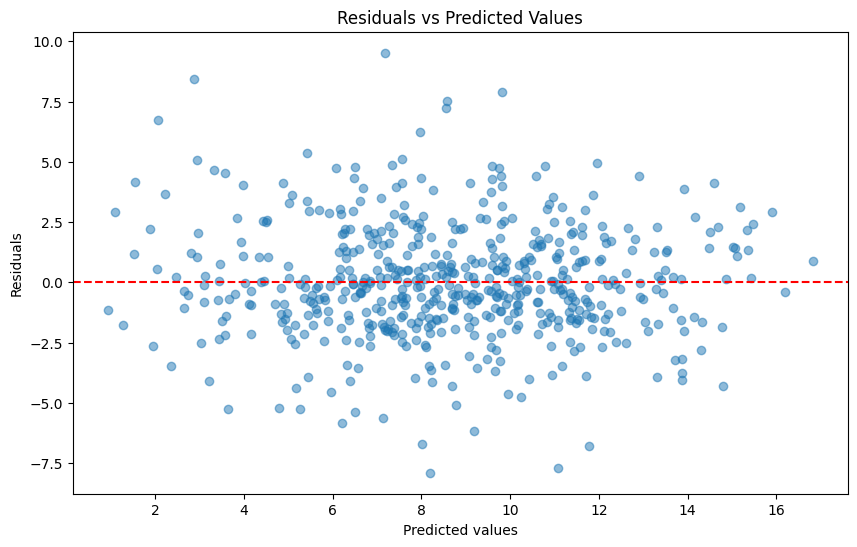

In [216]:
#Residual analysis - residuals look randomly distributed. 
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.savefig('Images/Residuals_RandomForest_PCA.png')
plt.show()


Observations: Residuals plot shows constant variance.

Random Forest Model with PCA Parameters Fine Tuning - Hyperparameter Tuning with GridSearchCV

In [215]:
# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV with Random Forest and the parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate the model with the best parameters
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)

# Evaluate performance
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f"Best MSE: {mse_best}")
print(f"Best R²: {r2_best}")



Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best MSE: 2.861815136373351
Best R²: 0.801391276269761


Observations: 

Best MSE:on average, the squared differences between predicted and actual PIE (Player Impact Estimate) values is around 2.86 units.

Best R² Score: 80.14% of the variance in the Player Impact Estimate (PIE) is explained by the model, which is fairly good for a Random Forest model.

<h4>  PCA Random Forest Model Validation

In [71]:
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean()} ± {cv_scores.std()}")

Cross-Validation R² Scores: [0.81367646 0.82695174 0.78922581 0.77013483 0.78940919]
Mean CV R²: 0.7978796081285336 ± 0.02005561344567731


The Random Forest model is stable and consistent across different subsets of the data, with a mean R² of 0.798 and low variability between folds. This reinforces that the model generalizes well and is unlikely to be overfitting on specific parts of the dataset.

<h4>  Random Forest Model without PCA 

In [217]:
# Use the original dataset without standardizing before splitting
X_no_pca = nba_df_no_outlier[performance_metrics]  # Use the performance metrics as features
y = nba_df_no_outlier['PIE']  # The dependent variable (Player Impact Estimate)

# Split the data into training and testing sets (80% train, 20% test)
X_train_no_pca, X_test_no_pca, y_train, y_test = train_test_split(X_no_pca, y, test_size=0.2, random_state=42)

# Apply Standardization after splitting the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no_pca)  # Fit only on training data
X_test_scaled = scaler.transform(X_test_no_pca)  # Use the same scaler for test data

# Fit and evaluate the Random Forest model on scaled data
rf_model_no_pca = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_no_pca.fit(X_train_scaled, y_train)

# Predict the test set
y_pred_no_pca = rf_model_no_pca.predict(X_test_scaled)

# Evaluate the model without PCA
mse_no_pca = mean_squared_error(y_test, y_pred_no_pca)
r2_no_pca = r2_score(y_test, y_pred_no_pca)
mae_no_pca = mean_absolute_error(y_test, y_pred_no_pca)

# Print results
print(f'MSE without PCA: {mse_no_pca}')
print(f'R² Score without PCA: {r2_no_pca}')
print(f'MAE without PCA: {mae_no_pca}')



MSE without PCA: 2.8671683528336387
R² Score without PCA: 0.8010197653795164
MAE without PCA: 1.2952266910420476


In [142]:
# Hyperparameter Tuning Without PCA:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search_no_pca = GridSearchCV(estimator=rf_model_no_pca, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit GridSearchCV to the original feature set
grid_search_no_pca.fit(X_train_scaled, y_train)

# Get the best parameters
print(f"Best parameters without PCA: {grid_search_no_pca.best_params_}")

# Evaluate the model with the best parameters
best_rf_no_pca = grid_search_no_pca.best_estimator_
y_pred_best_no_pca = best_rf_no_pca.predict(X_test_scaled)

# Evaluate the performance
mse_best_no_pca = mean_squared_error(y_test, y_pred_best_no_pca)
r2_best_no_pca = r2_score(y_test, y_pred_best_no_pca)
print(f"Best MSE without PCA: {mse_best_no_pca}")
print(f"Best R² Score without PCA: {r2_best_no_pca}")


Best parameters without PCA: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best MSE without PCA: 2.8424327191409926
Best R² Score without PCA: 0.8027364075818428


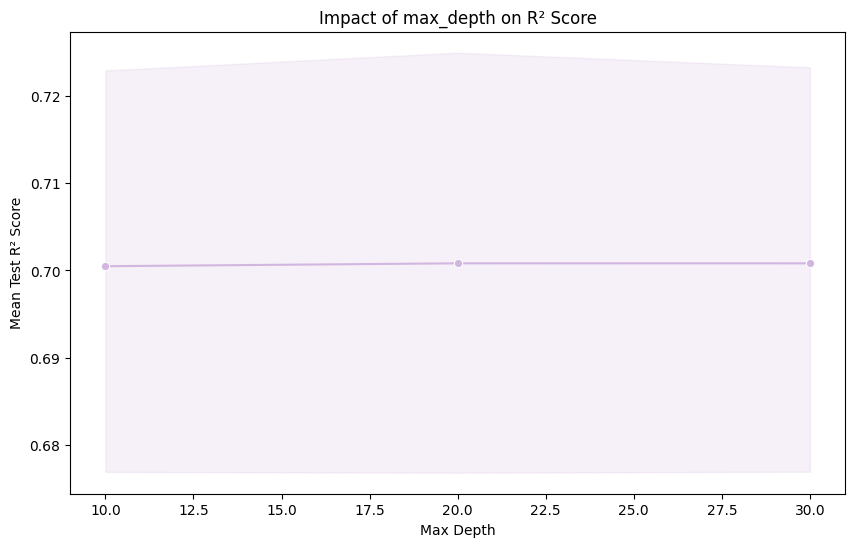

In [218]:
# Extract and plot the CV results from GridSearchCV
cv_results = pd.DataFrame(grid_search.cv_results_)

# Visualize the impact of 'max_depth' on R² Score
plt.figure(figsize=(10, 6))
sns.lineplot(x=cv_results['param_max_depth'], y=cv_results['mean_test_score'], marker='o', color=light_purple)
plt.title('Impact of max_depth on R² Score')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test R² Score')
plt.savefig('Images/Max_Depth_Impact.png')
plt.show()

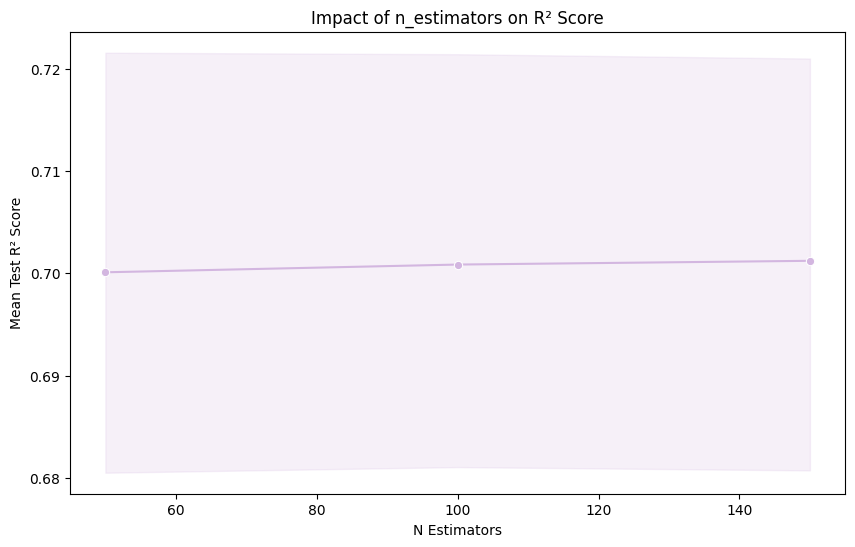

In [219]:
# Extract and plot the CV results from GridSearchCV
cv_results = pd.DataFrame(grid_search.cv_results_)

# Visualize the impact of 'n estimators' on R² Score
plt.figure(figsize=(10, 6))
sns.lineplot(x=cv_results['param_n_estimators'], y=cv_results['mean_test_score'], marker='o', color=light_purple)
plt.title('Impact of n_estimators on R² Score')
plt.xlabel('N Estimators')
plt.ylabel('Mean Test R² Score')
plt.savefig('Images/N_Estimator_Impact.png')
plt.show()

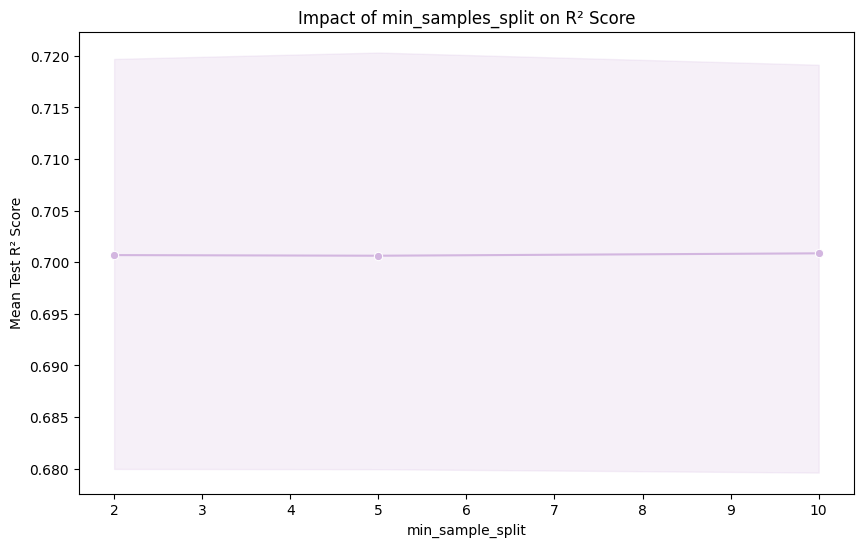

In [220]:
# Extract and plot the CV results from GridSearchCV
cv_results = pd.DataFrame(grid_search.cv_results_)

# Visualize the impact of 'max_depth' on R² Score
plt.figure(figsize=(10, 6))
sns.lineplot(x=cv_results['param_min_samples_split'], y=cv_results['mean_test_score'], marker='o', color=light_purple)
plt.title('Impact of min_samples_split on R² Score')
plt.xlabel('min_sample_split')
plt.ylabel('Mean Test R² Score')
plt.savefig('Images/Min_Sample_Split_Impact.png')
plt.show()

Observations: The flat nature of the line across the different values of x_depth, n_estimator, min_Sample split suggests that this parameter does not have a strong influence on model performance within the tested range.

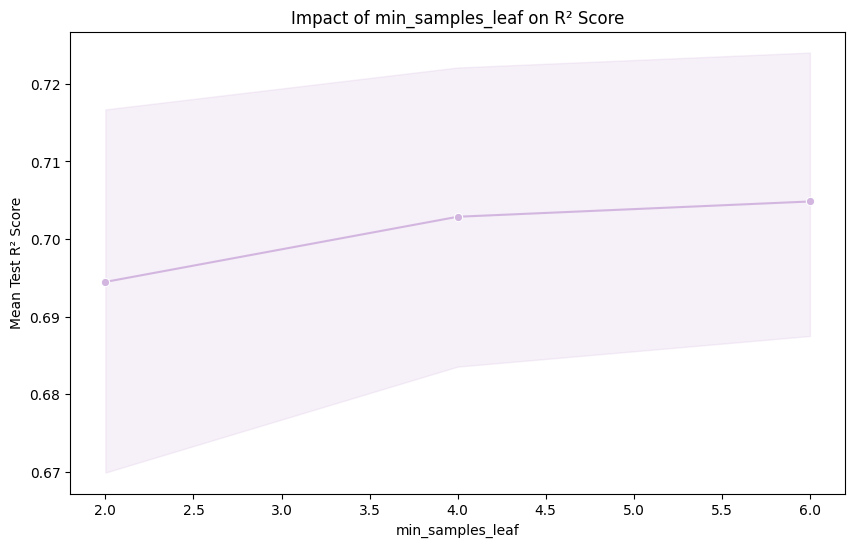

In [221]:
# Extract and plot the CV results from GridSearchCV
cv_results = pd.DataFrame(grid_search.cv_results_)

# Visualize the impact of 'max_depth' on R² Score
plt.figure(figsize=(10, 6))
sns.lineplot(x=cv_results['param_min_samples_leaf'], y=cv_results['mean_test_score'], marker='o', color=light_purple)
plt.title('Impact of min_samples_leaf on R² Score')
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean Test R² Score')
plt.savefig('Images/Min_Sample_Leaf_Impact.png')
plt.show()

Observations: Min_samples_leaf parameter has a noticeable impact on the R² score

In [153]:
#Re run Hyperparameter Tuning Without PCA:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search_no_pca = GridSearchCV(estimator=rf_model_no_pca, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit GridSearchCV to the original feature set
grid_search_no_pca.fit(X_train_scaled, y_train)

# Get the best parameters
print(f"Best parameters without PCA: {grid_search_no_pca.best_params_}")

# Evaluate the model with the best parameters
best_rf_no_pca = grid_search_no_pca.best_estimator_
y_pred_best_no_pca = best_rf_no_pca.predict(X_test_scaled)

# Evaluate the performance
mse_best_no_pca = mean_squared_error(y_test, y_pred_best_no_pca)
r2_best_no_pca = r2_score(y_test, y_pred_best_no_pca)
print(f"Best MSE without PCA: {mse_best_no_pca}")
print(f"Best R² Score without PCA: {r2_best_no_pca}")


Best parameters without PCA: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best MSE without PCA: 2.846849689658053
Best R² Score without PCA: 0.8024298717521878


Observation: Model without PCA performs marginally better than the one with PCA in terms of both R² score and MSE. This suggests that keeping all features (without dimensionality reduction) might capture the underlying structure of the data more accurately.

Top 10 Important Features (Without PCA):
TS%         0.341007
USG%        0.211921
DREB%       0.164519
AST%        0.075018
MIN         0.060135
DEFRTG      0.032926
TO RATIO    0.032720
AST/TO      0.024437
OREB%       0.020894
OFFRTG      0.014462
dtype: float64


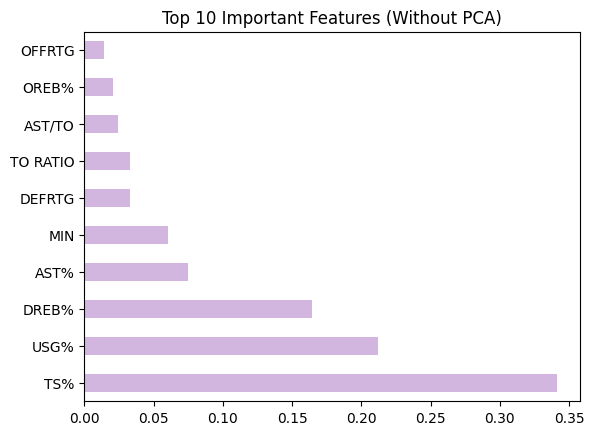

In [222]:
# Get feature importances from the Random Forest model
feature_importances_no_pca = pd.Series(best_rf_no_pca.feature_importances_, index=X_no_pca.columns)

# Sort and display the top 10 most important features
sorted_importances_no_pca = feature_importances_no_pca.sort_values(ascending=False)
print("Top 10 Important Features (Without PCA):")
print(sorted_importances_no_pca.head(10))

# Plot the top 10 important features
sorted_importances_no_pca.head(10).plot(kind='barh', title="Top 10 Important Features (Without PCA)", color=light_purple)
plt.savefig('Images/_Feature_Importance_RandomForest_wo_PCA.png')
plt.show()

Observation: Shooting efficiency (TS%) and usage (USG%) are the strongest predictors of player impact, followed by defensive rebounding and assisting metrics. This analysis aligns with conventional basketball wisdom, where scoring efficiency and involvement in plays drive a player's impact.

Cross-Validation on Random Forest Model without PCA:

In [135]:
# Perform 5-fold cross-validation
cv_scores_no_pca = cross_val_score(best_rf_no_pca, X_no_pca, y, cv=5, scoring='r2')

# Display the R² scores from each fold
print(f"Cross-Validation R² Scores (Without PCA): {cv_scores_no_pca}")
print(f"Mean R² Score: {cv_scores_no_pca.mean()}")
print(f"Standard Deviation of R² Score: {cv_scores_no_pca.std()}")

Cross-Validation R² Scores (Without PCA): [0.76639042 0.77216686 0.81303988 0.83595379 0.82238873]
Mean R² Score: 0.8019879365401644
Standard Deviation of R² Score: 0.027743455765976085


R² Scores: The individual R² scores from the 5-fold cross-validation range from 0.77 to 0.84, indicating that the model performs fairly well on all splits.

Mean R² Score: The mean R² score of 0.80 suggests that, on average, the model explains about 80% of the variance in the player performance metric (e.g., PIE), which is a solid result.

Standard Deviation: A standard deviation of 0.028 is small, indicating that the model's performance is quite consistent across different folds. This suggests that the model is stable and generalizes well to unseen data.


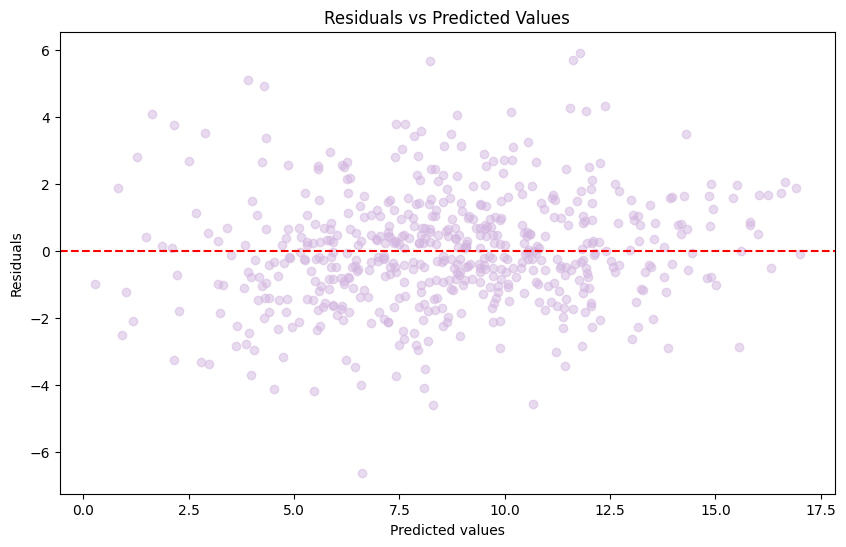

In [223]:
#Residual analysis
# Calculate residuals
residuals = y_test - y_pred_no_pca

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_no_pca, residuals, alpha=0.5, color = light_purple)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.savefig('Images/Residuals_RandomForest_wo_PCA.png')
plt.show()

Observation: Residuals appear to have constant variance.

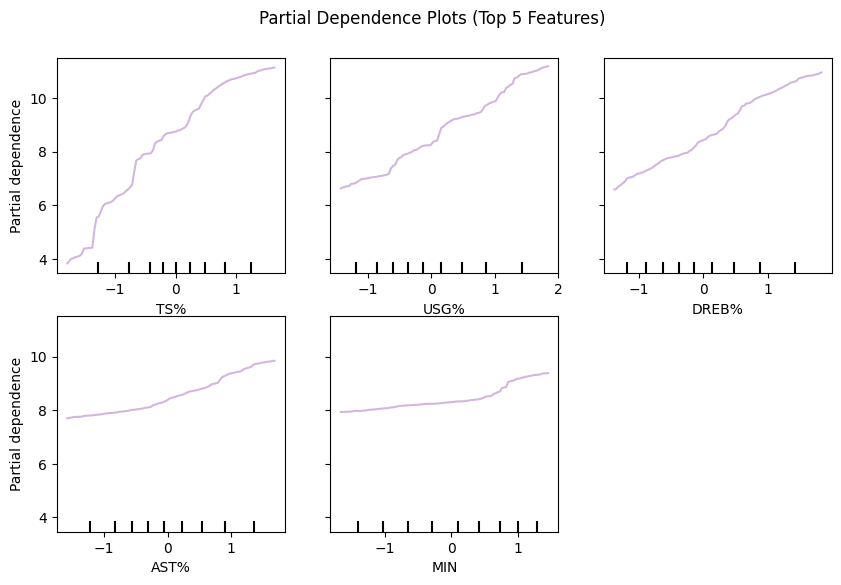

In [224]:
# Get the top 5 important feature names from the model (actual features, not PCA components)
important_features = sorted_importances_no_pca.index[:5]

# Extract the original feature names from the non-scaled training set
feature_names = X_no_pca.columns.tolist()

feature_names

# Plot partial dependence for the top important features using original feature names
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(rf_model_no_pca, X_train_scaled, 
                                        features=important_features, feature_names=feature_names, ax=ax,
                                        line_kw={"color": light_purple} )

plt.suptitle('Partial Dependence Plots (Top 5 Features)')
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.savefig('Images/Partial_Dependency_RF_wo_PCA.png')
plt.show()

Observation: Overall, these partial dependence plots reveal that key performance metrics such as shooting efficiency (TS%), usage (USG%), and rebounding (DREB%) significantly contribute to higher player performance (PIE). These insights align with the intuition that more efficient and active players, who contribute across various metrics, tend to perform better.

<h4> Feature Engineerings on Random Forest Model Without PCA<h4>

In [225]:
nba_df_no_outlier.head()

AGE   MIN  OFFRTG  DEFRTG      AST%  AST/TO     OREB%  DREB%  TO RATIO  \
1   25  15.1   114.6    99.4  1.269136    1.25 -0.957195    4.7      11.3   
2   27  30.7   107.7   118.7  0.226103    1.50  1.514536   18.9      10.8   
3   27  32.8    97.5   105.4 -0.457770    0.86  0.274201   13.8       9.2   
4   24  28.8   102.9   110.5 -0.364138    1.00 -0.451942    8.1      18.2   
7   31  37.4   100.3   106.6 -0.333800    0.82 -0.451942   28.1      15.1   

    TS%  USG%    PACE   PIE  
1  48.9  31.3  104.26   5.9  
2  55.8  17.8   93.29  10.6  
3  48.7  19.7   92.32   7.3  
4  43.3  11.6   92.65   0.6  
7  48.2  15.8   90.24  12.2

In [226]:
# Create interaction between offensive and defensive ratings
nba_df_no_outlier['OFFRTG_DEFRTG'] = nba_df_no_outlier['OFFRTG'] / nba_df_no_outlier['DEFRTG']

# Create polynomial features
nba_df_no_outlier['MIN_SQ'] = nba_df_no_outlier['MIN'] ** 2
nba_df_no_outlier['USG_SQ'] = nba_df_no_outlier['USG%'] ** 2


# Bin AGE into categories
nba_df_no_outlier['AGE_BIN'] = pd.cut(nba_df_no_outlier['AGE'], bins=[20, 25, 30, 40], labels=['young', 'prime', 'veteran'])

# One-Hot Encode the AGE_BIN categorical feature
nba_df_no_outlier = pd.get_dummies(nba_df_no_outlier, columns=['AGE_BIN'], drop_first=True)


In [227]:
nba_df_no_outlier.head()

AGE   MIN  OFFRTG  DEFRTG      AST%  AST/TO     OREB%  DREB%  TO RATIO  \
1   25  15.1   114.6    99.4  1.269136    1.25 -0.957195    4.7      11.3   
2   27  30.7   107.7   118.7  0.226103    1.50  1.514536   18.9      10.8   
3   27  32.8    97.5   105.4 -0.457770    0.86  0.274201   13.8       9.2   
4   24  28.8   102.9   110.5 -0.364138    1.00 -0.451942    8.1      18.2   
7   31  37.4   100.3   106.6 -0.333800    0.82 -0.451942   28.1      15.1   

    TS%  USG%    PACE   PIE  OFFRTG_DEFRTG   MIN_SQ  USG_SQ  AGE_BIN_prime  \
1  48.9  31.3  104.26   5.9       1.152918   228.01  979.69          False   
2  55.8  17.8   93.29  10.6       0.907329   942.49  316.84           True   
3  48.7  19.7   92.32   7.3       0.925047  1075.84  388.09           True   
4  43.3  11.6   92.65   0.6       0.931222   829.44  134.56          False   
7  48.2  15.8   90.24  12.2       0.940901  1398.76  249.64          False   

   AGE_BIN_veteran  
1            False  
2            False  
3            False  
4            False  
7             True

In [228]:
# Update the performance metrics to include new engineered features (excluding target variable 'PIE')
performance_metrics_new = ['MIN', 'OFFRTG', 'DEFRTG', 'TS%', 'USG%', 'AST%', 'AST/TO', 
                    'OREB%', 'DREB%', 'TO RATIO', 'PACE', 'AGE', 'OFFRTG_DEFRTG', 'MIN_SQ', 'USG_SQ', 'AGE_BIN_prime','AGE_BIN_veteran'
                    ]

# Splitting the data into features (X) and target (y)
X_no_pca = nba_df_no_outlier[performance_metrics_new]
y = nba_df_no_outlier['PIE']  # The dependent variable (Player Impact Estimate)

# Split the data into training and testing sets (80% train, 20% test)
X_train_no_pca, X_test_no_pca, y_train, y_test = train_test_split(X_no_pca, y, test_size=0.2, random_state=42)

# Apply Standardization after splitting the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_no_pca)  # Fit only on training data
X_test_scaled = scaler.transform(X_test_no_pca)  # Use the same scaler for test data

# Initialize and fit the Random Forest Regressor on the engineered feature set
rf_model_no_pca = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_no_pca.fit(X_train_scaled, y_train)

# Predict the test set
y_pred_no_pca = rf_model_no_pca.predict(X_test_scaled)

# Evaluate the model without PCA
mse_no_pca = mean_squared_error(y_test, y_pred_no_pca)
r2_no_pca = r2_score(y_test, y_pred_no_pca)

print(f'MSE without PCA: {mse_no_pca}')
print(f'R² Score without PCA: {r2_no_pca}')


MSE without PCA: 2.856912495429617
R² Score without PCA: 0.8017315174154476


In [229]:
# Feature Importance Analysis
feature_importances_no_pca = pd.Series(rf_model_no_pca.feature_importances_, index=X_no_pca.columns)

# Sort the feature importances in descending order
sorted_importances_no_pca = feature_importances_no_pca.sort_values(ascending=False)

# Display the top 10 most important features
print("Top 10 Important Features:\n", sorted_importances_no_pca.head(10))

# Perform 5-fold cross-validation to evaluate model performance
cv_scores_no_pca = cross_val_score(rf_model_no_pca, X_no_pca, y, cv=5, scoring='r2')

# Display the R² scores from each fold
print(f"Cross-Validation R² Scores (Without PCA): {cv_scores_no_pca}")
print(f"Mean R² Score: {cv_scores_no_pca.mean()}")
print(f"Standard Deviation of R² Score: {cv_scores_no_pca.std()}")

Top 10 Important Features:
 TS%         0.330762
DREB%       0.161119
USG_SQ      0.116522
USG%        0.091663
AST%        0.076090
MIN         0.035596
TO RATIO    0.032546
MIN_SQ      0.029859
DEFRTG      0.029762
AST/TO      0.023701
dtype: float64
Cross-Validation R² Scores (Without PCA): [0.76362051 0.77118695 0.81038546 0.83432761 0.81981337]
Mean R² Score: 0.7998667799563116
Standard Deviation of R² Score: 0.027685310259669787


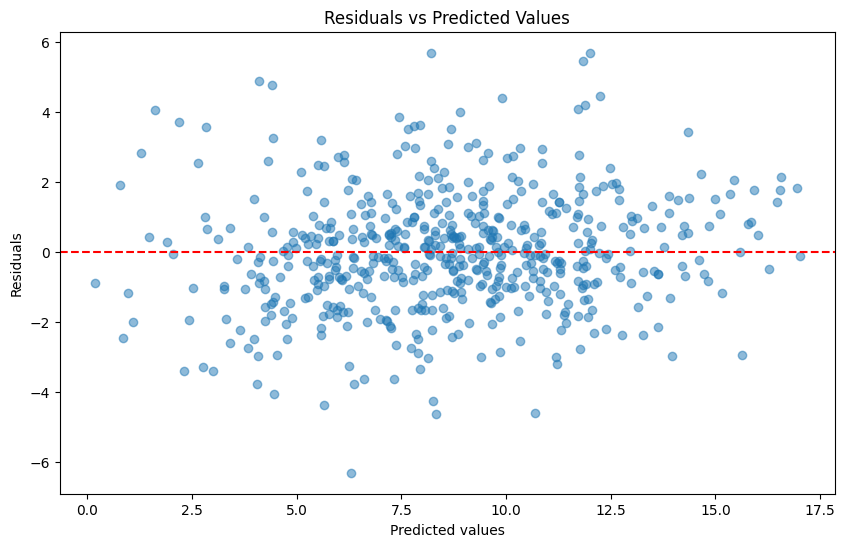

In [230]:
#Residual analysis
# Calculate residuals
residuals = y_test - y_pred_no_pca

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_no_pca, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.savefig('Images/Residuals_RF_Feature_Engineering.png')
plt.show()

In [119]:
# Perform 5-fold cross-validation
cv_scores_engineered = cross_val_score(rf_model_no_pca, X, y, cv=5, scoring='r2')

# Display the R² scores from each fold
print(f"Cross-Validation R² Scores (With Engineered Features): {cv_scores_engineered}")
print(f"Mean R² Score: {cv_scores_engineered.mean()}")
print(f"Standard Deviation of R² Score: {cv_scores_engineered.std()}")


Cross-Validation R² Scores (With Engineered Features): [0.76409451 0.77348792 0.8125215  0.83554024 0.8230912 ]
Mean R² Score: 0.8017470737457029
Standard Deviation of R² Score: 0.028035455028077264


Observation: Random forest model with featuring engineering performs similarly to the model without. However given the top 10 important features don't include any of those feature engineering variables, I will choose the simpler model without feature engineering.

<h4> Neutral Network Model <h4>

In [231]:
nba_df_no_outlier.head()

AGE   MIN  OFFRTG  DEFRTG      AST%  AST/TO     OREB%  DREB%  TO RATIO  \
1   25  15.1   114.6    99.4  1.269136    1.25 -0.957195    4.7      11.3   
2   27  30.7   107.7   118.7  0.226103    1.50  1.514536   18.9      10.8   
3   27  32.8    97.5   105.4 -0.457770    0.86  0.274201   13.8       9.2   
4   24  28.8   102.9   110.5 -0.364138    1.00 -0.451942    8.1      18.2   
7   31  37.4   100.3   106.6 -0.333800    0.82 -0.451942   28.1      15.1   

    TS%  USG%    PACE   PIE  OFFRTG_DEFRTG   MIN_SQ  USG_SQ  AGE_BIN_prime  \
1  48.9  31.3  104.26   5.9       1.152918   228.01  979.69          False   
2  55.8  17.8   93.29  10.6       0.907329   942.49  316.84           True   
3  48.7  19.7   92.32   7.3       0.925047  1075.84  388.09           True   
4  43.3  11.6   92.65   0.6       0.931222   829.44  134.56          False   
7  48.2  15.8   90.24  12.2       0.940901  1398.76  249.64          False   

   AGE_BIN_veteran  
1            False  
2            False  
3            False  
4            False  
7             True

In [232]:
# Define X (features) and y (target) again
X = nba_df_no_outlier.drop(['PIE', 'OFFRTG_DEFRTG', 'USG_SQ',
                    'MIN_SQ', 'AGE_BIN_prime', 'AGE_BIN_veteran'], axis=1)  # Features
y = nba_df_no_outlier['PIE']  # Target variable (PIE)
# Check for NaN in y before splitting
print("Check for NaN in y before splitting:", y.isnull().sum())

Check for NaN in y before splitting: 0


In [233]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for NaN values in y_train and y_test after the split
print("Check for NaN in y_train after split:", y_train.isnull().sum())
print("Check for NaN in y_test after split:", y_test.isnull().sum())

# If NaNs persist, let's inspect the values
print("y_test sample values:", y_test.head())

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check for NaN values in X_test_scaled and y_test after processing
print("Check for NaN in X_test_scaled:", np.isnan(X_test_scaled).any())
print("Check for NaN in y_test:", np.isnan(y_test).any())  # This should now be False

Check for NaN in y_train after split: 0
Check for NaN in y_test after split: 0
y_test sample values: 1450     3.2
2700     6.6
3743    10.2
1382     6.8
109      8.7
Name: PIE, dtype: float64
Check for NaN in X_test_scaled: False
Check for NaN in y_test: False


In [234]:
# Define the Neural Network architecture
model = Sequential()

# Input layer with L2 regularization
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l2(0.01)))

# Hidden layer 1 with L2 regularization
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# Hidden layer 2 with L2 regularization
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))

# Output layer (no activation function for regression task)
model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=100, batch_size=32, verbose=0)

# Predict on the test set
y_pred_nn_clean = model.predict(X_test_scaled)

# Evaluate performance
mse_nn = mean_squared_error(y_test, y_pred_nn_clean)
mae_nn = mean_absolute_error(y_test, y_pred_nn_clean)
r2_nn = r2_score(y_test, y_pred_nn_clean)
rmse_nn = mean_squared_error(y_test, y_pred_nn_clean, squared=False)


# Print evaluation metrics
print(f'Mean Squared Error (MSE): {mse_nn}')
print(f'Mean Absolute Error (MAE): {mae_nn}')
print(f'R² Score: {r2_nn}')
print(f'Root Mean Squared Error (RMSE): {rmse_nn}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error (MSE): 2.4190987302614873
Mean Absolute Error (MAE): 1.1459623906414076
R² Score: 0.8321156019869496
Root Mean Squared Error (RMSE): 1.5553452125690577


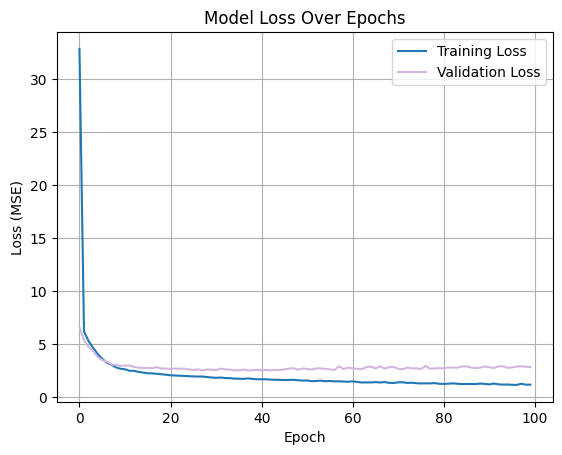

In [237]:
# Plot training & validation loss values over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', color=light_purple)
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('Images/Model_Loss_NNM.png')
plt.show()

Observations: 

(1) Around 5-10 epochs, there is a significant decrease in both training and validation loss, which means the model is well-functioning and learning from the data.
(2) After around 20 epochs, both the training and validation loss stabilize and hover around the same value.
(3) The gap between the training and validation loss is small, suggesting that the model is not significantly overfitting.

Neural Network Hyperparameters Fine Tuning:

In [239]:
# Define the function to create the neural network model
def create_model(num_neurons1=32, num_neurons2=16, num_neurons3=8, learning_rate=0.001, l2_reg=0.01):
    model = Sequential()
    model.add(Dense(num_neurons1, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(Dense(num_neurons2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(Dense(num_neurons3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(Dense(1, activation='linear'))  # Linear activation for regression
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


# Ensure data is ready and clean (for demonstration purposes, X_train_scaled, X_test_scaled, y_train, y_test are assumed to be prepared)
# Define X (features) and y (target) again
X = nba_df_no_outlier.drop(['PIE', 'OFFRTG_DEFRTG', 
                    'MIN_SQ', 'AGE_BIN_prime', 'AGE_BIN_veteran'], axis=1)  # Features
y = nba_df_no_outlier['PIE']  # Target variable (PIE)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Wrap the model using SciKeras for compatibility with Scikit-Learn's RandomizedSearchCV
model = KerasRegressor(model=create_model, verbose=0)

# Define the hyperparameter space
param_dist = {
    'model__num_neurons1': [16, 32, 64, 128,256],  # Number of neurons in the first hidden layer
    'model__num_neurons2': [16, 32, 64, 128, 256],   # Number of neurons in the second hidden layer
    'model__num_neurons3': [8, 16, 32, 64, 128],    # Number of neurons in the third hidden layer
    'model__learning_rate': [0.01, 0.005, 0.001, 0.0005],  # Learning rate
    'model__l2_reg': [0.01, 0.005, 0.001],  # L2 regularization strength
    'epochs': [50, 100, 150, 200],  # Number of training epochs
    'batch_size': [8, 16, 32, 64]  # Batch size
}

# Set up RandomizedSearchCV with 3-fold cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object 

Best Parameters: {'model__num_neurons3': 8, 'model__num_neurons2': 128, 'model__num_neurons1': 16, 'model__learning_rate': 0.001, 'model__l2_reg': 0.01, 'epochs': 50, 'batch_size': 16}
Mean Squared Error: 1.9477725240797146
R² Score: 0.8648254353652874


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Mean Squared Error (MSE) of the best model: 2.0153834281748173
R² Score of the best model: 0.8601332680754069


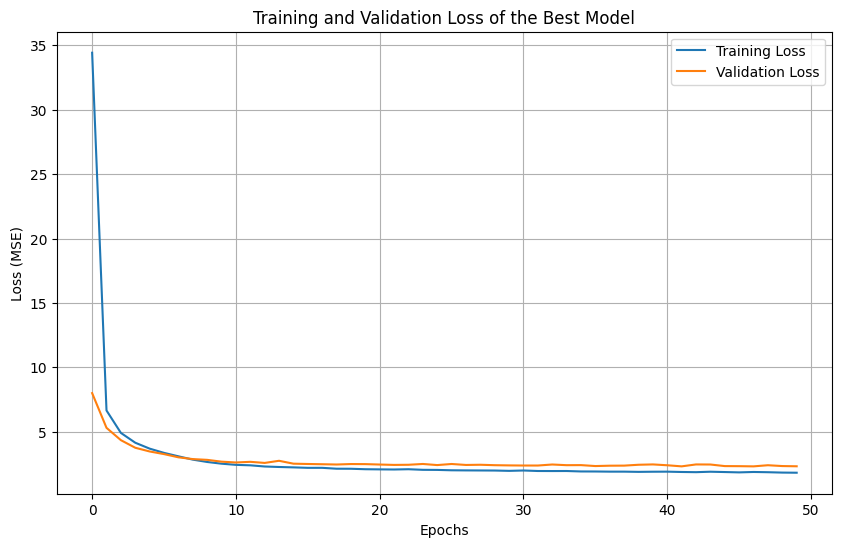

In [240]:
# Get the best parameters from the RandomizedSearchCV
best_params = random_search.best_params_

# Build the model again using the best parameters
best_model = KerasRegressor(model=create_model, 
                            num_neurons1=best_params['model__num_neurons1'], 
                            num_neurons2=best_params['model__num_neurons2'], 
                            num_neurons3=best_params['model__num_neurons3'], 
                            l2_reg=best_params['model__l2_reg'],
                            verbose=0)

# Train the best model on the training data and retrieve the history
best_model.fit(X_train_scaled, y_train, 
            validation_data=(X_test_scaled, y_test), 
            epochs=best_params['epochs'], 
            batch_size=best_params['batch_size'], 
            verbose=0)

# SciKeras stores the training history in the `best_model.history_` attribute
history = best_model.history_

# Predict on the test set
y_pred_best = best_model.predict(X_test_scaled)

# Evaluate performance
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Print the results
print(f"Mean Squared Error (MSE) of the best model: {mse_best}")
print(f"R² Score of the best model: {r2_best}")

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of the Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('Images/Model_Loss_NNM_Best_Model.png')
plt.show()

Observation: (1) Both the training and validation loss decrease significantly in the early epochs, indicating that the model is learning well at the start.
(2) Around 10 epochs, both the training and validation loss flatten out and stabilize, which suggests that the model has converged, and no further improvements are being made with additional epochs.
(3) No Major Overfitting: The validation loss tracks closely with the training loss, which is a positive sign. There is no significant gap between the two, indicating that the model generalizes well and isn't overfitting to the training data.

<h4> Neural Network Model 2 with Adam Optimizer with decay

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object 

Best Parameters: {'model__num_neurons3': 16, 'model__num_neurons2': 64, 'model__num_neurons1': 128, 'model__learning_rate': 0.005, 'model__l2_reg': 0.001, 'epochs': 50, 'batch_size': 32}
Mean Squared Error: 1.9055665891487241
R² Score: 0.8677545088627141


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Mean Squared Error (MSE) of the best model: 2.026143007126891
R² Score of the best model: 0.8593865579834845


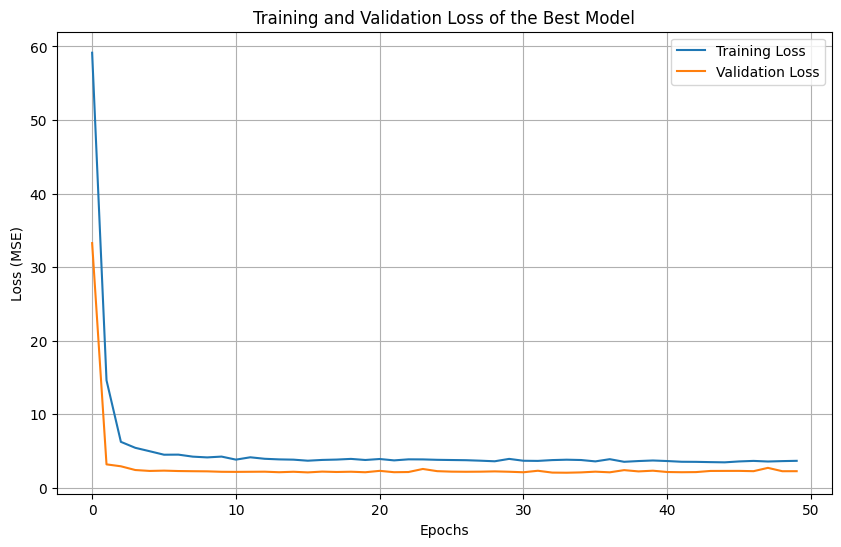

In [242]:
# Define the function to create the neural network model
def create_model(num_neurons1=32, num_neurons2=16, num_neurons3=8, learning_rate=0.001, l2_reg=0.01):
    model = Sequential()
    # First hidden layer with Batch Normalization and Dropout
    model.add(Dense(num_neurons1, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Second hidden layer
    model.add(Dense(num_neurons2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Third hidden layer
    model.add(Dense(num_neurons3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='linear'))  # Linear activation for regression
    
    # Adam optimizer with decay
    optimizer = Adam(learning_rate=learning_rate, decay=1e-6)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Ensure data is ready and clean (using nba_df_no_outlier as provided before)
# Define X (features) and y (target)
X = nba_df_no_outlier.drop(['PIE', 'OFFRTG_DEFRTG', 'MIN_SQ', 'AGE_BIN_prime', 'AGE_BIN_veteran'], axis=1)  # Features
y = nba_df_no_outlier['PIE']  # Target variable (PIE)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Wrap the model using SciKeras for compatibility with Scikit-Learn's RandomizedSearchCV
model = KerasRegressor(model=create_model, verbose=0)

# Define the hyperparameter space
param_dist = {
    'model__num_neurons1': [16, 32, 64, 128],  # Number of neurons in the first hidden layer
    'model__num_neurons2': [16, 32, 64, 128],  # Number of neurons in the second hidden layer
    'model__num_neurons3': [8, 16, 32, 64],    # Number of neurons in the third hidden layer
    'model__learning_rate': [0.01, 0.005, 0.001, 0.0005],  # Learning rate
    'model__l2_reg': [0.01, 0.005, 0.001],  # L2 regularization strength
    'epochs': [50, 100],  # Number of training epochs
    'batch_size': [16, 32]  # Batch size
}

# Set up RandomizedSearchCV with 3-fold cross-validation
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Train the best model with the chosen parameters and retrieve the history
best_model.fit(X_train_scaled, y_train,
            validation_data=(X_test_scaled, y_test),
            epochs=best_params['epochs'],
            batch_size=best_params['batch_size'],
            verbose=0)

# Get the training history
history = best_model.history_

# Predict on the test set again for the final evaluation
y_pred_best = best_model.predict(X_test_scaled)

# Evaluate final performance
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Print the final results
print(f"Mean Squared Error (MSE) of the best model: {mse_best}")
print(f"R² Score of the best model: {r2_best}")

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of the Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('Images/Model_Loss_NNM_Adam_Decay.png')
plt.show()


Observation: This neural network with Adam optimizer with decay performs slightly worse than the one without decay.